In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import statsmodels.api as sm
%config InlineBackend.figure_format='retina'
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
plt.rc('axes',titlesize=30)
plt.rc('axes',labelsize=30)
plt.rc('font',size=50)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize= 15)
pd.set_option('display.max_row', 50000)

# 미국 10년물 국채 수익률과 증시지수와의 관계

## 1. 기본 데이터셋 준비

## 1.1 Selenium이용 naver에서 Nasdaq 웹 크롤링

In [3]:
## 네이버에서 가져오기 ()
##  time.sleep을 삽입해 중복과 누락데이터의 발생을 줄였다.
## 대신 크롤링 속도가 현저하게 줄어듬.
## 나스닥
dv = webdriver.Chrome()
dv.get('https://finance.naver.com/main/main.nhn')
time.sleep(1)
## 해외증시로
world = dv.find_element_by_css_selector('#menu > ul > li.m3 > a ')
world.click()
time.sleep(1)
## 나스닥 종합으로 
nsd = dv.find_element_by_css_selector('#americaIndex > thead > tr:nth-child(4) > td.tb_td2 > a')
nsd.click()
time.sleep(1)
## 해당 페이지에서 columns 수집
soup = BeautifulSoup(dv.page_source,'html.parser')
col = soup.select('#dayTable > thead > tr > th')
column_list = []
for item in col:
    column_list.append(item.text)
time.sleep(1)
rate = soup.select('#dayTable > tbody > tr > td')
row_list = []
df1_list=[]
cnt = 0
for row in rate:
    row_list.append(row.text)
for index in range(int(len(row_list)/6)):
    df1_list.append(row_list[cnt:cnt+6])
    cnt+=6
i = 2
while True :
    try:
        nextbtn = dv.find_element_by_css_selector('#dayLink'+str(i))
        nextbtn.click()
        time.sleep(1)
        soup = BeautifulSoup(dv.page_source,'html.parser')
        rate = soup.select('#dayTable > tbody > tr > td')
        row_list = []
        cnt = 0
        for row in rate:
            row_list.append(row.text)
        for index in range(int(len(row_list)/6)):
            df1_list.append(row_list[cnt:cnt+6])
            cnt+=6
        if i%10==0:
            nextbtn2 = dv.find_element_by_css_selector('#dayPaging > a.next')
            nextbtn2.click()
            time.sleep(1)
        i+=1
    except:
        break
time.sleep(1)
dv.close()

In [4]:
# list -> DataFrame
nasdaq = pd.DataFrame(df1_list, columns=column_list)

In [5]:
# 개수
# 총 485페이지중 1페이지당 10개씩 마지막 페이지 6개
# 다 가져옴
len(nasdaq)

4846

In [6]:
# 중복확인
# 중복없음 확인
nasdaq.duplicated().sum()

0

In [7]:
# columns변형
nasdaq.columns = ['Date','Close','delete','Open','High','Low']
nasdaq = nasdaq[['Date','Open','High','Low','Close']]

In [4]:
# Date columns dtype을 datetime으로
nasdaq['Date']=nasdaq['Date'].str.replace('.','-')
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4846 non-null   datetime64[ns]
 1   Open    4846 non-null   float64       
 2   High    4846 non-null   float64       
 3   Low     4846 non-null   float64       
 4   Close   4846 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 189.4 KB


In [9]:
# object - > float
nasdaq['Open'] = nasdaq['Open'].str.replace(',','')
nasdaq['Open'] = nasdaq['Open'].astype('float')
nasdaq['High'] = nasdaq['High'].str.replace(',','')
nasdaq['High'] = nasdaq['High'].astype('float')
nasdaq['Low'] = nasdaq['Low'].str.replace(',','')
nasdaq['Low'] = nasdaq['Low'].astype('float')
nasdaq['Close'] = nasdaq['Close'].str.replace(',','')
nasdaq['Close'] = nasdaq['Close'].astype('float')

In [10]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4846 non-null   datetime64[ns]
 1   Open    4846 non-null   float64       
 2   High    4846 non-null   float64       
 3   Low     4846 non-null   float64       
 4   Close   4846 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 189.4 KB


In [11]:
# 1970~2001년 사이의 csv 데이터와 결합하기 위해 시간순 정렬
nasdaq=nasdaq.sort_index(ascending=False)

In [126]:
# CSV 파일로 내보내기
nasdaq.to_csv('02_21NASDAQ.csv',sep=',',encoding='utf8')

## 1.2 Selenium이용 naver에서 S&P500웹 크롤링

In [13]:
## 네이버에서 가져오기 ()
## S&P500
dv = webdriver.Chrome()
dv.get('https://finance.naver.com/main/main.nhn')
time.sleep(1)
## 해외증시로
world = dv.find_element_by_css_selector('#menu > ul > li.m3 > a ')
world.click()
time.sleep(1)
## S&P500으로 
spx = dv.find_element_by_css_selector('#americaIndex > thead > tr:nth-child(6) > td.tb_td2 > a')
spx.click()
time.sleep(1)
## 해당 페이지에서 columns 수집
soup = BeautifulSoup(dv.page_source,'html.parser')
col = soup.select('#dayTable > thead > tr > th')
column_list = []
for item in col:
    column_list.append(item.text)
time.sleep(1)
rate = soup.select('#dayTable > tbody > tr > td')
row_list = []
df_list=[]
cnt = 0
for row in rate:
    row_list.append(row.text)
for index in range(int(len(row_list)/6)):
    df_list.append(row_list[cnt:cnt+6])
    cnt+=6
i = 2
while True :
    try:
        nextbtn = dv.find_element_by_css_selector('#dayLink'+str(i))
        nextbtn.click()
        time.sleep(1)
        soup = BeautifulSoup(dv.page_source,'html.parser')
        rate = soup.select('#dayTable > tbody > tr > td')
        row_list = []
        cnt = 0
        for row in rate:
            row_list.append(row.text)
        for index in range(int(len(row_list)/6)):
            df_list.append(row_list[cnt:cnt+6])
            cnt+=6
        if i%10==0:
            nextbtn2 = dv.find_element_by_css_selector('#dayPaging > a.next')
            nextbtn2.click()
            time.sleep(1)
        i+=1
    except:
        break
time.sleep(1)
dv.close()

In [14]:
# list -> DataFrame
snp500 = pd.DataFrame(df_list, columns=column_list)

In [15]:
# 개수
# 총 485페이지중 1페이지당 10개씩 마지막 페이지 9개
# 다 가져옴
len(snp500)

4849

In [16]:
# 중복확인
# 중복없음 확인
snp500.duplicated().sum()

0

In [17]:
# columns변형
snp500.columns = ['Date','Close','delete','Open','High','Low']
snp500 = snp500[['Date','Open','High','Low','Close']]

In [3]:
# Date columns dtype을 datetime으로
snp500['Date'] = snp500['Date'].str.replace('.','-')
snp500['Date'] = pd.to_datetime(snp500['Date'])
snp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4849 entries, 0 to 4848
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4849 non-null   datetime64[ns]
 1   Open    4849 non-null   float64       
 2   High    4849 non-null   float64       
 3   Low     4849 non-null   float64       
 4   Close   4849 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 189.5 KB


In [19]:
# object - > float
snp500['Open'] = snp500['Open'].str.replace(',','')
snp500['Open'] = snp500['Open'].astype('float')
snp500['High'] = snp500['High'].str.replace(',','')
snp500['High'] = snp500['High'].astype('float')
snp500['Low'] = snp500['Low'].str.replace(',','')
snp500['Low'] = snp500['Low'].astype('float')
snp500['Close'] = snp500['Close'].str.replace(',','')
snp500['Close'] = snp500['Close'].astype('float')

In [20]:
snp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4849 entries, 0 to 4848
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4849 non-null   datetime64[ns]
 1   Open    4849 non-null   float64       
 2   High    4849 non-null   float64       
 3   Low     4849 non-null   float64       
 4   Close   4849 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 189.5 KB


In [21]:
# 1970~2001년 사이의 csv 데이터와 결합하기 위해 시간순 정렬
snp500=snp500.sort_index(ascending=False)

In [22]:
snp500.head()

,Date,Open,High,Low,Close
4848,2002-01-02,1148.08,1154.67,1136.23,1154.67
4847,2002-01-03,1154.67,1165.27,1154.01,1165.27
4846,2002-01-04,1165.27,1176.55,1163.42,1172.51
4845,2002-01-07,1172.51,1176.97,1163.55,1164.89
4844,2002-01-08,1164.89,1167.60,1157.46,1160.71


In [129]:
# CSV 파일로 내보내기
snp500.to_csv('02_21SPX.csv',sep=',',encoding='utf8')

In [2]:
## 저장된 데이터 불러오기
## 편집시 사용
nasdaq = pd.read_csv('02_21NASDAQ.csv',sep=',')
snp500 = pd.read_csv('02_21SPX.csv',sep=',')
nasdaq = nasdaq[['Date','Open','High','Low','Close']]
snp500 = snp500[['Date','Open','High','Low','Close']]

## 1.3 CSV파일과 데이터 결합

In [5]:
## nasdaq 결합
## 나스닥 종합 1970.1.2~2001.12.31까지의 자료
## 앞에 nasdaq와 결합하여 dataset 확보할 예정
ndq_70_01 = pd.read_csv('data/^ndq_d(70.1.2~01.12.31).csv',parse_dates=['Date'])

In [24]:
# 결합전 dataset 자료수
len(nasdaq),len(ndq_70_01)

(4846, 8081)

In [6]:
# 결합
ndq = pd.concat([ndq_70_01,nasdaq])
len(ndq)

12927

In [83]:
# 중복확인
ndq.duplicated().sum()

0

In [7]:
# 인덱스 초기화
ndq = ndq.reset_index(drop=True)

In [8]:
## s&p500 결합
## S&P 500 지수 1970.1.2~2001.12.31까지의 자료
## 앞에 snp500과 결합하여 dataset 확보할 예정
snp_70_01 = pd.read_csv('data/^spx_d(70.01.02~01.12.31).csv',parse_dates=['Date'])

In [29]:
# 결합전 dataset 자료수
len(snp500),len(snp_70_01)

(4849, 8082)

In [9]:
# 결합
spx = pd.concat([snp_70_01,snp500])
len(spx)

12931

In [87]:
# 중복확인
spx.duplicated().sum()

0

In [10]:
# 인덱스 초기화
spx = spx.reset_index(drop=True)

In [11]:
#나머지 dataset
# 자료 출처 : https://stooq.com/
kospi = pd.read_csv('data/^kospi_d.csv',parse_dates=['Date'])
ten_usy = pd.read_csv('data/10usy_b_d2.csv',parse_dates=['Date'])
usd_krw = pd.read_csv('data/usdkrw_d.csv',parse_dates=['Date'])
# kospi는 seleninum으로 추출실패.
# 나머지 자료는 확보가 어려워 자료 출처에서 csv파일로 가져왔다.

In [147]:
# 각 데이터 개수
len(ndq),len(spx),len(kospi),len(ten_usy),len(usd_krw)

(12927, 12931, 11027, 12720, 10052)

In [ ]:
# 데이터 범위
# ndq(1970-01-02~2021-04-01)
# spx(1970-01-02~2021-04-01)
# kospi(1980-01-04~2021-04-01)
# ten_usy(1970-05-01~2021-03-26)
# usd_krw(1981-04-13~2021-03-26)

In [12]:
# 지수변동률 Columns = per로 dataset에 추가
# ndq per 구하는 공식 및 추가
per=[]
for i in range(len(ndq)-1):
    result = ((ndq['Close'][i+1]-ndq['Close'][i])/ndq['Close'][i])*100
    per.append(result)
# 첫번째 데이터의 전날 종가지수가 없음으로 0을 추가해준다.

    # 첫번째 데이터의 전날 종가지수가 없음으로 0을 추가해준다.
per
per.insert(0,0)
per = pd.DataFrame(per,columns=['per'])
ndq = pd.concat([ndq,per],axis=1)

In [13]:
# spx per 구하는 공식 및 추가
per=[]
for i in range(len(spx)-1):
    result = ((spx['Close'][i+1]-spx['Close'][i])/spx['Close'][i])*100
    per.append(result)
# 첫번째 데이터의 전날 종가지수가 없음으로 0을 추가해준다.
per.insert(0,0)
per
per = pd.DataFrame(per,columns=['per'])
spx = pd.concat([spx,per],axis=1)

In [14]:
# kospi per 구하는 공식 및 추가
per=[]
for i in range(len(kospi)-1):
    result = ((kospi['Close'][i+1]-kospi['Close'][i])/kospi['Close'][i])*100
    per.append(result)
# 첫번째 데이터의 전날 종가지수가 없음으로 0을 추가해준다.
per.insert(0,0)
per
per = pd.DataFrame(per,columns=['per'])
kospi = pd.concat([kospi,per],axis=1)

In [15]:
# ten_usy는 애당초 수익률이다.
# ten_usy per 구하는 공식 및 추가 
per=[]
for i in range(1,len(ten_usy)):
    result = ten_usy['Close'][i] - ten_usy['Close'][i-1]
    per.append(result)
# 첫번째 데이터의 전날 종가지수가 없음으로 0을 추가해준다.
per.insert(0,0)
per
per = pd.DataFrame(per,columns=['per'])
ten_usy = pd.concat([ten_usy,per],axis=1)

In [16]:
# 자료정제
# Date,Close,per 필요
ndq = ndq[['Date','Close','per']]
spx = spx[['Date','Close','per']]
kospi = kospi[['Date','Close','per']]
ten_usy = ten_usy[['Date','Close','per']]
usd_krw = usd_krw[['Date','Close']]

In [17]:
# kospi는 80년도 부터 시작함으로 ten_usy또한 시작값을 같게 만든다.
ten_usy80 = ten_usy.iloc[ten_usy.loc[ten_usy['Date']=='1980-01-04'].index[0]:]
ten_usy80.reset_index(drop=True,inplace=True)
ten_usy80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10310 entries, 0 to 10309
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10310 non-null  datetime64[ns]
 1   Close   10310 non-null  float64       
 2   per     10310 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 241.8 KB


In [39]:
# ndq_info
ndq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12927 entries, 0 to 12926
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12927 non-null  datetime64[ns]
 1   Close   12927 non-null  float64       
 2   per     12927 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 303.1 KB


In [40]:
# spx_info
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12931 entries, 0 to 12930
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12931 non-null  datetime64[ns]
 1   Close   12931 non-null  float64       
 2   per     12931 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 303.2 KB


In [154]:
# kospi_info
kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11027 entries, 0 to 11026
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11027 non-null  datetime64[ns]
 1   Close   11027 non-null  float64       
 2   per     11027 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 258.6 KB


In [149]:
# ten_usy_info
ten_usy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12720 entries, 0 to 12719
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12720 non-null  datetime64[ns]
 1   Close   12720 non-null  float64       
 2   per     12720 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 298.2 KB


In [150]:
#usd_krw_info
usd_krw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10052 entries, 0 to 10051
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10052 non-null  datetime64[ns]
 1   Close   10052 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 157.2 KB


In [ ]:
## 자료가 방대한  https://stooq.com/ 에서
## Selenium 을 사용한 dataset을 시도했지만 
## 해당 사이트 페이지 사용시 하루 한도를 초과한
## 트래픽을 사용하면 랜덤으로 팝업창이 발생하고 해당 페이지 사용 불가능.
## 웹 크롤링을 통한 dataset을 만드는 것은 실패하였다.
## 사용 불가능하기 전까지 사용가능한 코드를 첨부하였다.
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
###ndq 지수 리스트 웹크롤링
dv = webdriver.Chrome()
dv.get('https://stooq.com/')
elem= dv.find_element_by_id('cmp0a')
elem.clear()
elem.send_keys('^NDQ') # 원하는 지수명 입력하면 가진다.
elem.send_keys(Keys.RETURN)
time.sleep(1)
his = dv.find_element_by_css_selector('#q_m_1 > table:nth-child(3) > tbody > tr > td > table > tbody > tr:nth-child(10) > td:nth-child(2) > a')
his.click()
time.sleep(1)
input_y = dv.find_element_by_name('d3')
input_y.clear()
input_y.send_keys('1970') # kospi는 자동으로 1980년으로 가진다.
input_y.send_keys(Keys.RETURN)
time.sleep(1)
soup = BeautifulSoup(dv.page_source,'html.parser')
col = soup.select('#fth1 > thead > #f13 > td:nth-child(-n+6)')
columns = []
df_list = []
for item in col:
    columns.append(item.text)
li = soup.select('#fth1 > tbody#f13 > tr > td:nth-child(-n+7)')
# 주식데이터 list 
row_list = []
cnt = 0
for row in li:
    row_list.append(row.text)
for i in range(int(len(row_list)/7)):
    df_list.append(row_list[cnt:cnt+6])
    cnt+=7
time.sleep(1)
nextbtn = dv.find_element_by_css_selector('body > table:nth-child(2) > tbody > tr:nth-child(2) > td:nth-child(2) > table > tbody > tr > td:nth-child(1) > table > tbody > tr > td > table:nth-child(10) > tbody > tr > td > table > tbody > tr > td:nth-child(3) > table > tbody > tr > td:nth-child(1) > table:nth-child(4) > tbody > tr#r > td#f13 > a')
nextbtn.click()
time.sleep(1)
while True:    
    soup = BeautifulSoup(dv.page_source,'html.parser')
    li = soup.select('#fth1 > tbody#f13 > tr > td:nth-child(-n+7)')
    # 지수데이터 list 
    row_list = []
    cnt = 0
    for row in li:
        row_list.append(row.text)
    for i in range(int(len(row_list)/7)):
        df_list.append(row_list[cnt:cnt+6]) # NO,Date,Open,High,Low,close가 리스트로 중첩
        cnt+=7
    nextbtn2 = dv.find_element_by_css_selector('body > table:nth-child(2) > tbody > tr:nth-child(2) > td:nth-child(2) > table > tbody > tr > td:nth-child(1) > table > tbody > tr > td > table:nth-child(10) > tbody > tr > td > table > tbody > tr > td:nth-child(3) > table > tbody > tr > td:nth-child(1) > table:nth-child(4) > tbody > tr#r > td#f13 > a:nth-child(3)')
    nextbtn2.click()
    time.sleep(1)
    no = soup.select_one('#fth1 > tbody#f13 > tr:nth-last-child(1) > td:nth-child(1)')
    if no == 1:
        dv.close()
        break

In [ ]:
# 참고
# 미 국채 10년물 추이에 따른 지수의 추이는 어떠한가? 그에 따른 대응방식..
# http://www.hani.co.kr/arti/economy/finance/835229.html
## 자료수집
# https://stooq.com/

## 2. 2020~2021년 지수변화

In [25]:
# 네개의 데이터셋 모두 2020년 부터 2021년 3월 26일까지 재편성한다.
# 부득이하게 df,df2,df3는 하단에 존재함
# 3절먼저 실행후 올라서와 실행해야한다. 
ndq_20_21=df.loc[(df['Date'].dt.year == 2020) | (df['Date'].dt.year == 2021)]
spx_20_21=df2.loc[(df2['Date'].dt.year == 2020) | (df2['Date'].dt.year == 2021)]
kospi_20_21=df3.loc[(df3['Date'].dt.year == 2020) | (df3['Date'].dt.year == 2021)]

### 2.1 20~21년 Nasdaq , S&P 500, KOSPI 간 선그래프 

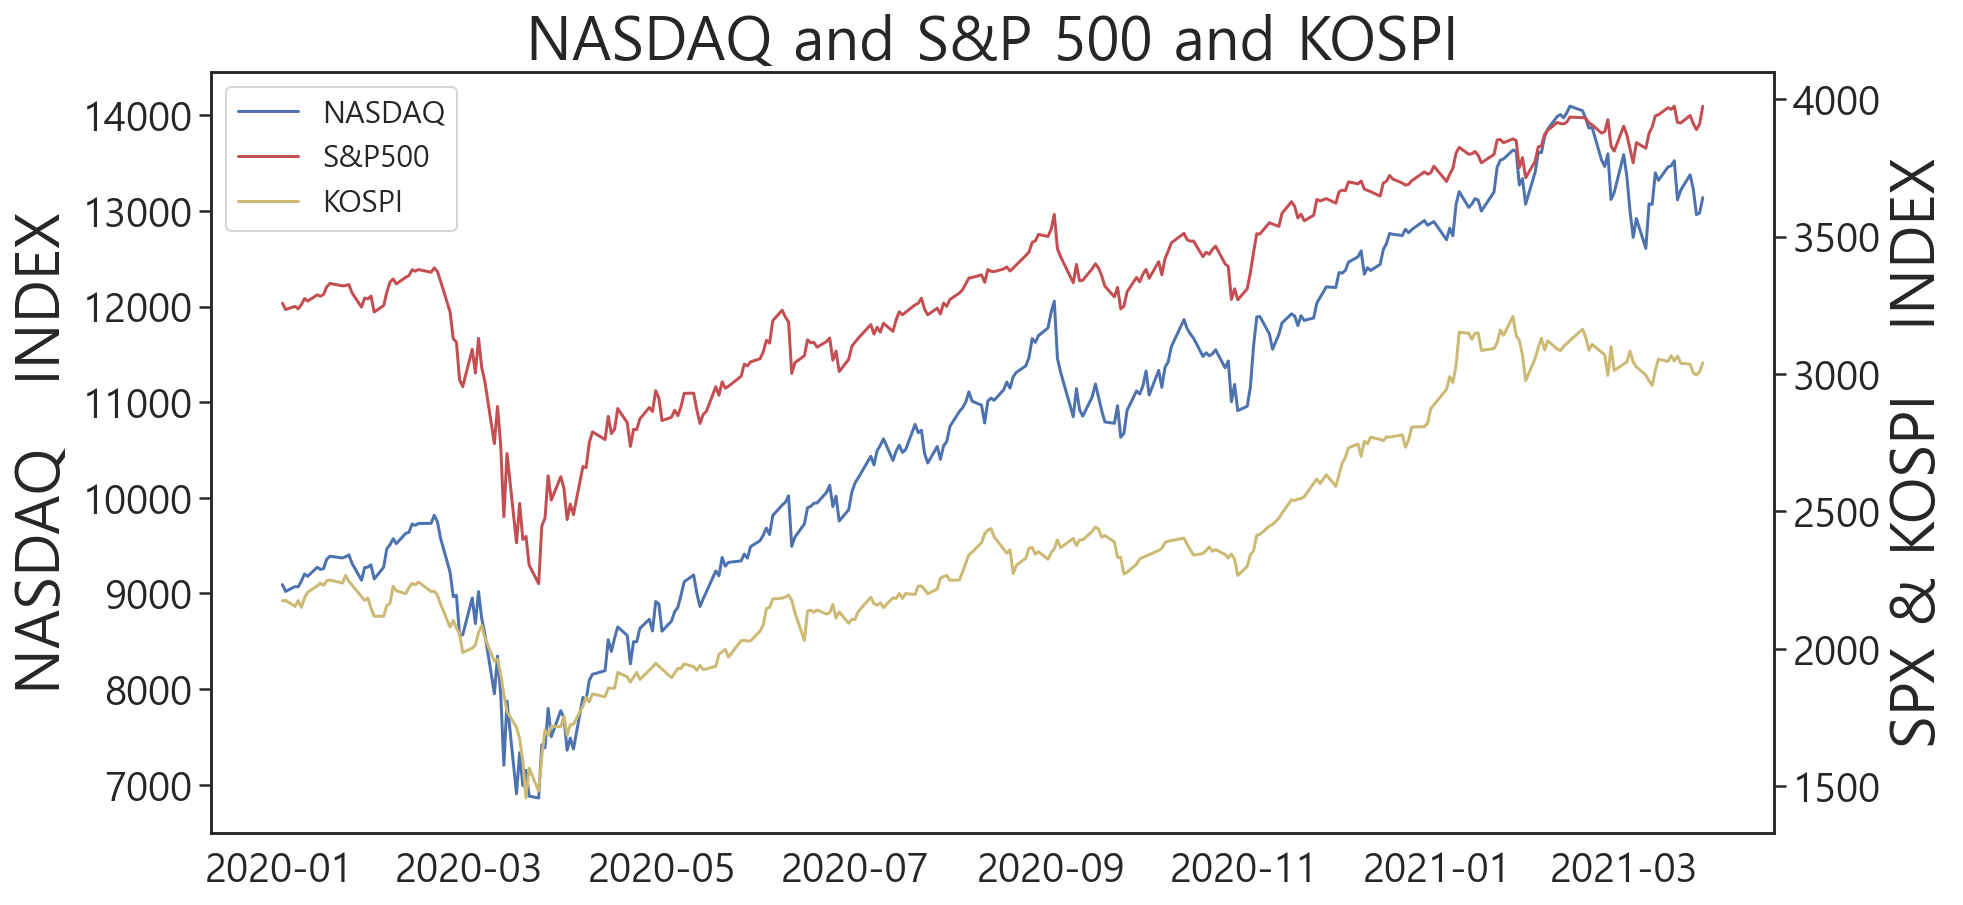

In [155]:
fig , ax = plt.subplots(figsize=(14,7))
ndqx = ax.plot('Date','ndq_c',data=ndq_20_21,color='b',label='NASDAQ')
ax.set_ylabel('NASDAQ   INDEX')
ax2 = ax.twinx()
ax2.set_ylabel('SPX & KOSPI   INDEX')
spxx = ax2.plot('Date','spx_c',data=spx_20_21,color='r',label='S&P500')
kospix = ax2.plot('Date','kospi_c',data=kospi_20_21,color='y',label='KOSPI')
plt.title('NASDAQ and S&P 500 and KOSPI')
xxx = ndqx+spxx+kospix
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=0)
plt.show()
#plt.savefig('NSK.png',bbox_inches='tight', pad_inches=0.5)

In [128]:
# 근래 2020년발생한 코로나로 인해 3월에 전세계 모든 증시가 폭락을했고 시간이 지남에 따라
# 빠르게 회복하고 있음을 보여준다. 2020년 3월부터 전세계에 주식광풍이 불었고 거기엔
# 대한민국도 예외는 아니였다.시간상 20년 8월~10월 조정기간을 지나 11월부터 모든 시장이
# 큰폭으로 상승하게된다. 이 상승은 21년도 1월까지 추진력을 얻고, 2월중순부터 급격한 상승에 대한 반납, 
# 조정장이 사작되어 지수에 큰 변화를 보여주진 못한다.
# 다만 21년도 2월이후 나스닥이 폭락한 반면 S&P500은 견고하게 지수를 지키고 있음을 보여주는데
# 이 시기가 바로 미 10년물 국채수익률이 급격히 상승하기 시작하는 기간이다.
# 단기적으로는 증시에 악영향을 미치고있는것 처럼 보이지만 장기적으로 봤을땐 어떠할까?

### 2.2 20~21년 각 지수와 미 국채 10년물 수익률간 선 그래프

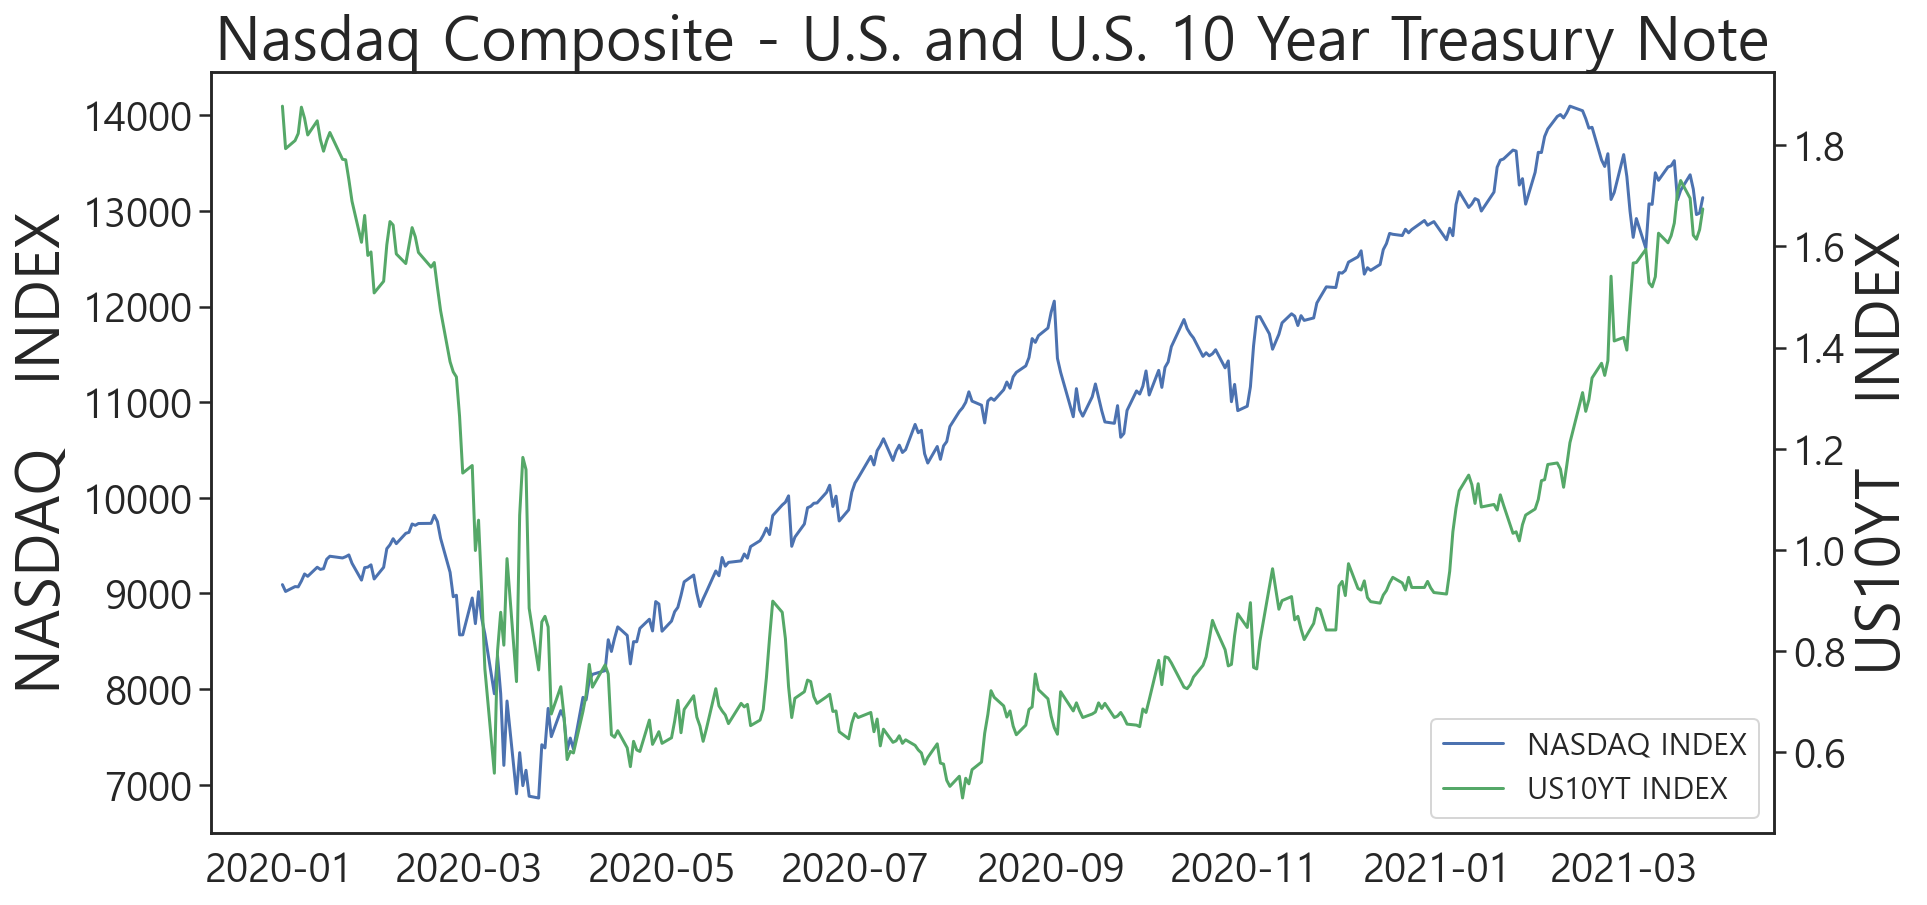

In [157]:
# 나스닥종합지수와 미국채 10년물 수익률간 선 그래프
fig , ax = plt.subplots(figsize=(14,7))
ndqx = ax.plot('Date','ndq_c',data=ndq_20_21,color='b',label='NASDAQ INDEX')
ax.set_ylabel('NASDAQ   INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','us10y_c',data=ndq_20_21,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT   INDEX')
plt.title('Nasdaq Composite - U.S. and U.S. 10 Year Treasury Note')
xxx = ndqx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=4)
plt.show()
#plt.savefig('2021_N10.png',bbox_inches='tight', pad_inches=0.5) 

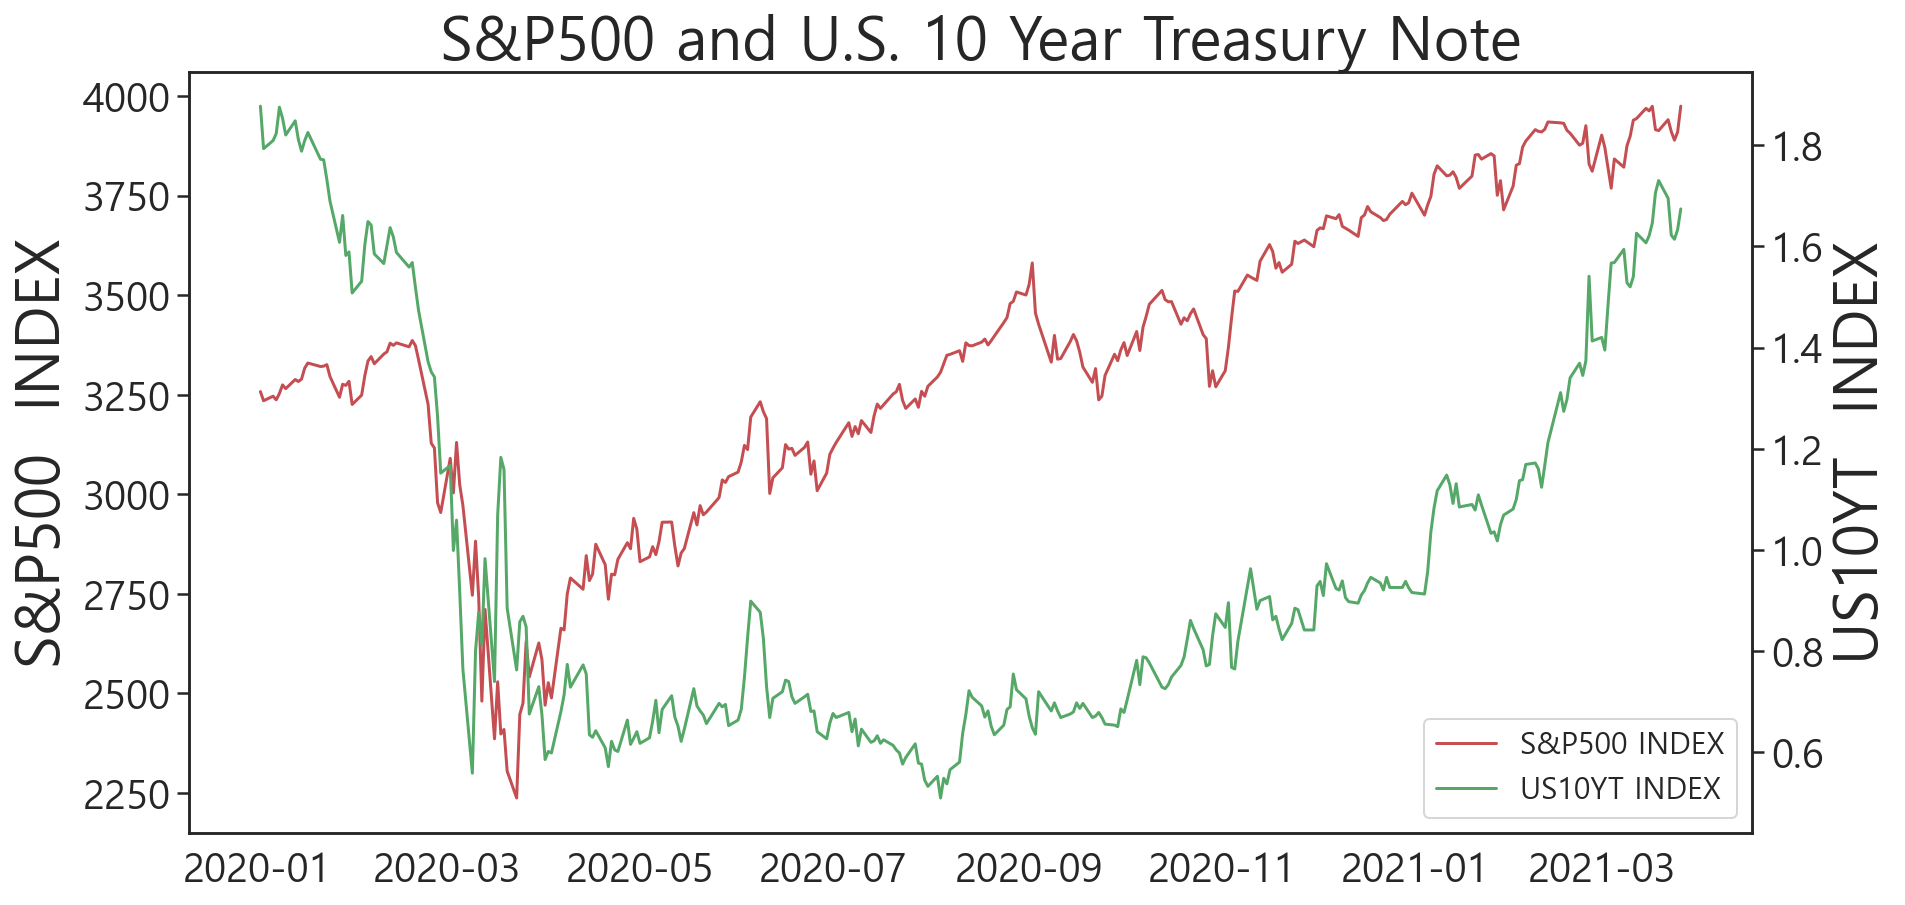

In [158]:
# S&P500지수와 미국채 10년물 수익률간 선 그래프
fig , ax = plt.subplots(figsize=(14,7))
spxx = ax.plot('Date','spx_c',data=spx_20_21,color='r',label='S&P500 INDEX')
ax.set_ylabel('S&P500  INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','us10y_c',data=spx_20_21,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' S&P500 and U.S. 10 Year Treasury Note')
xxx = spxx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=4)
plt.show()
#plt.savefig('2021_S10.png',bbox_inches='tight', pad_inches=0.5) 

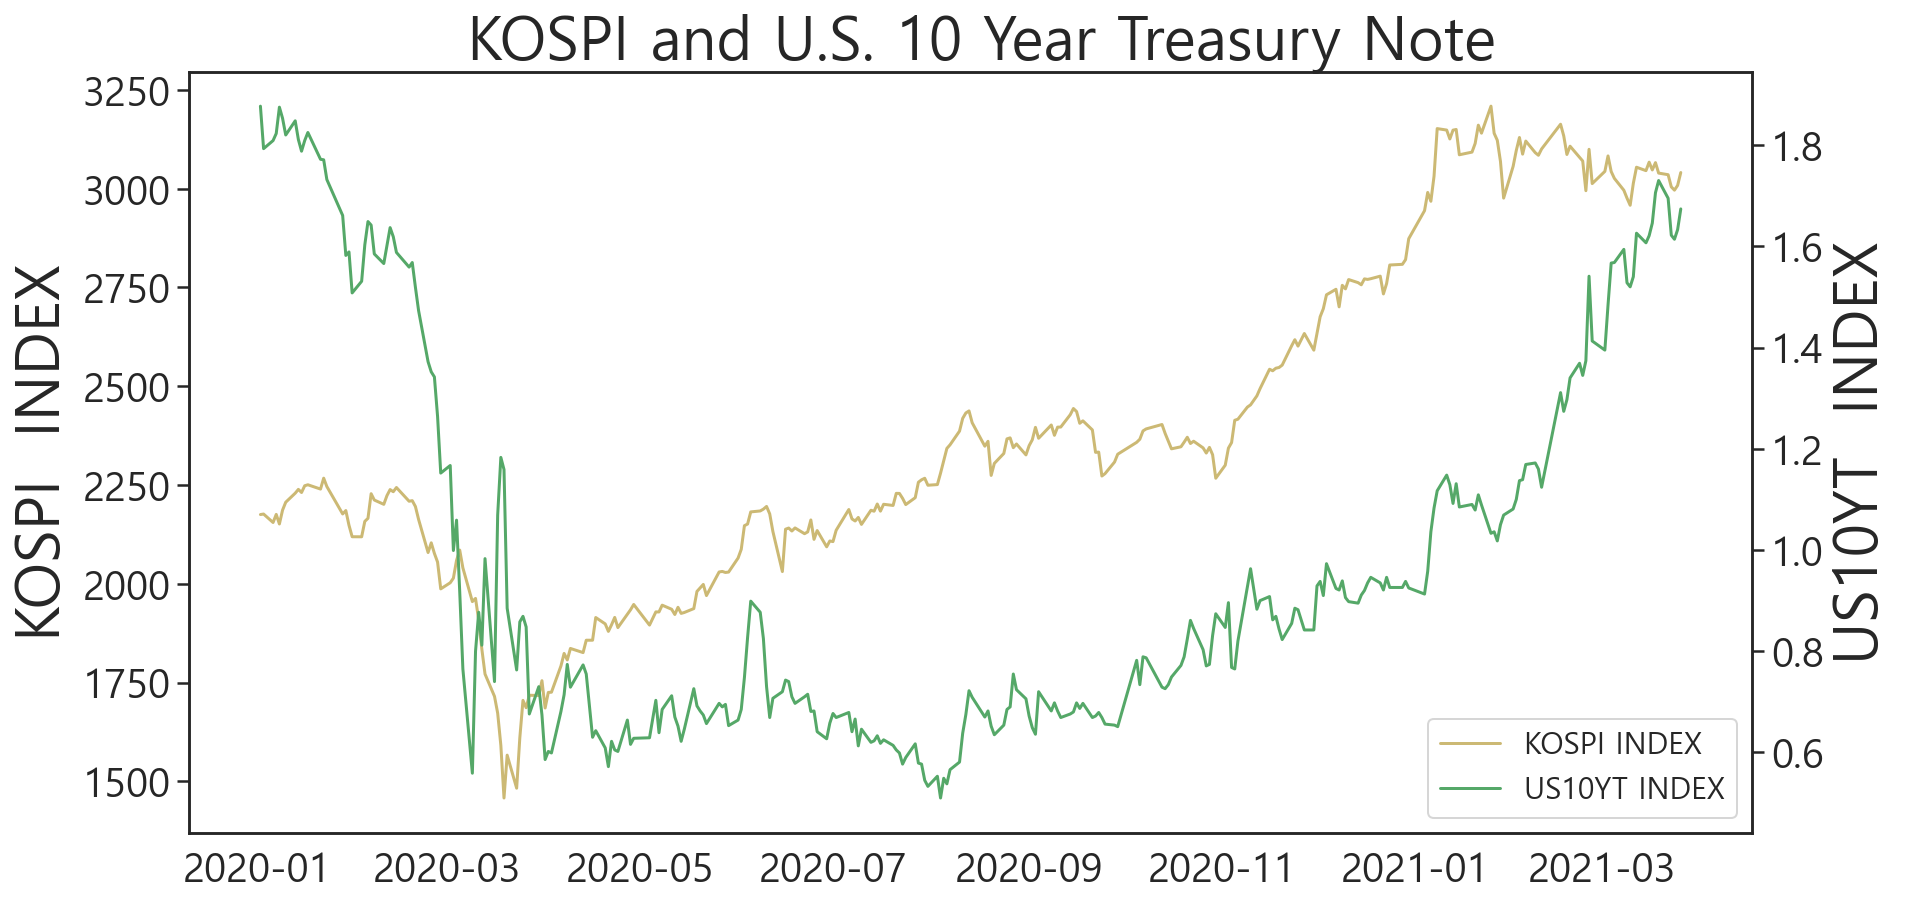

In [159]:
# Kospi지수와 미국채 10년물 수익률간 선 그래프
fig,ax = plt.subplots(figsize=(14,7))
kospix = ax.plot('Date','kospi_c',data=kospi_20_21,color='y',label='KOSPI INDEX')
ax.set_ylabel('KOSPI  INDEX')
ax2 = ax.twinx()
ten_usy80x = ax2.plot('Date','us10y_80_c',data=kospi_20_21,color='g',label='US10YT  INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' KOSPI and U.S. 10 Year Treasury Note')
xxx = kospix+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=4)
plt.show()
#plt.savefig('2021_K10.png',bbox_inches='tight', pad_inches=0.5) 

## 3. 미국채 10년물 수익률과 증시지수와의 선그래프 및 상관관계 분석

### 3.1 나스닥종합지수와 미국채 10년물 수익률 간 분석

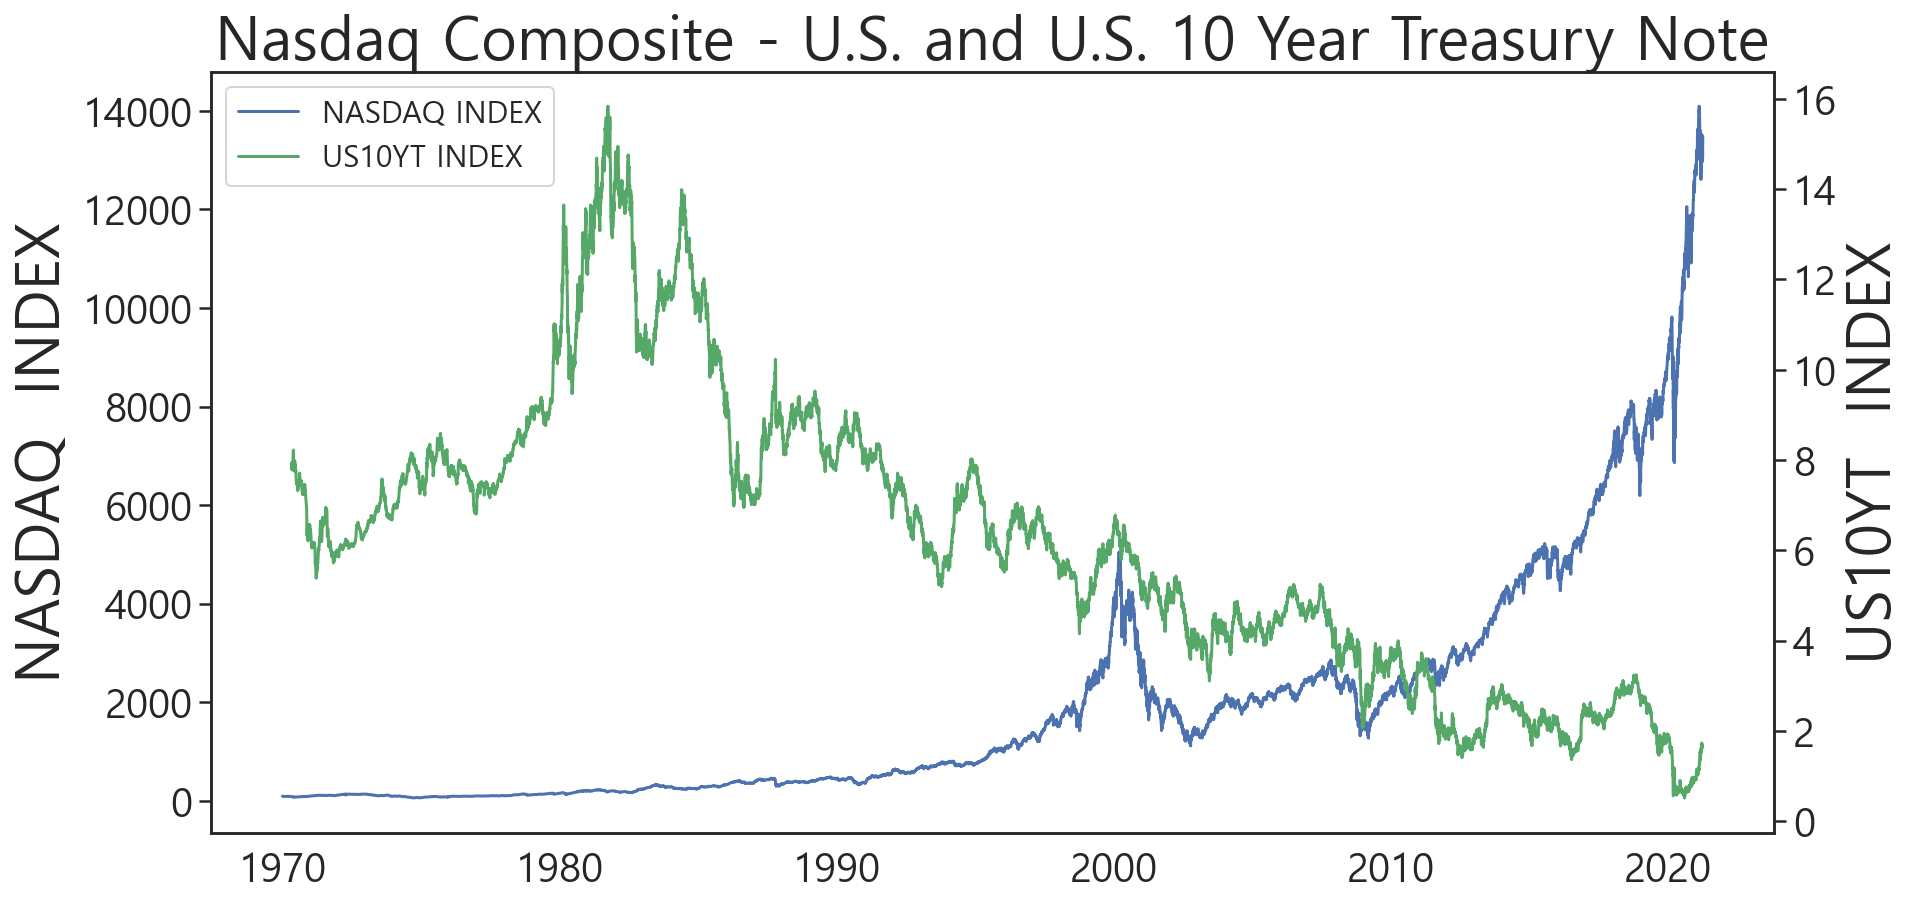

In [153]:
# 나스닥종합지수와 미국채 10년물 수익률간 선 그래프
fig , ax = plt.subplots(figsize=(14,7))
ndqx = ax.plot('Date','Close',data=ndq,color='b',label='NASDAQ INDEX')
ax.set_ylabel('NASDAQ  INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','Close',data=ten_usy,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title('Nasdaq Composite - U.S. and U.S. 10 Year Treasury Note')
xxx = ndqx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=2)
plt.show()
#plt.savefig('7021_NC.png',bbox_inches='tight', pad_inches=0.5)  

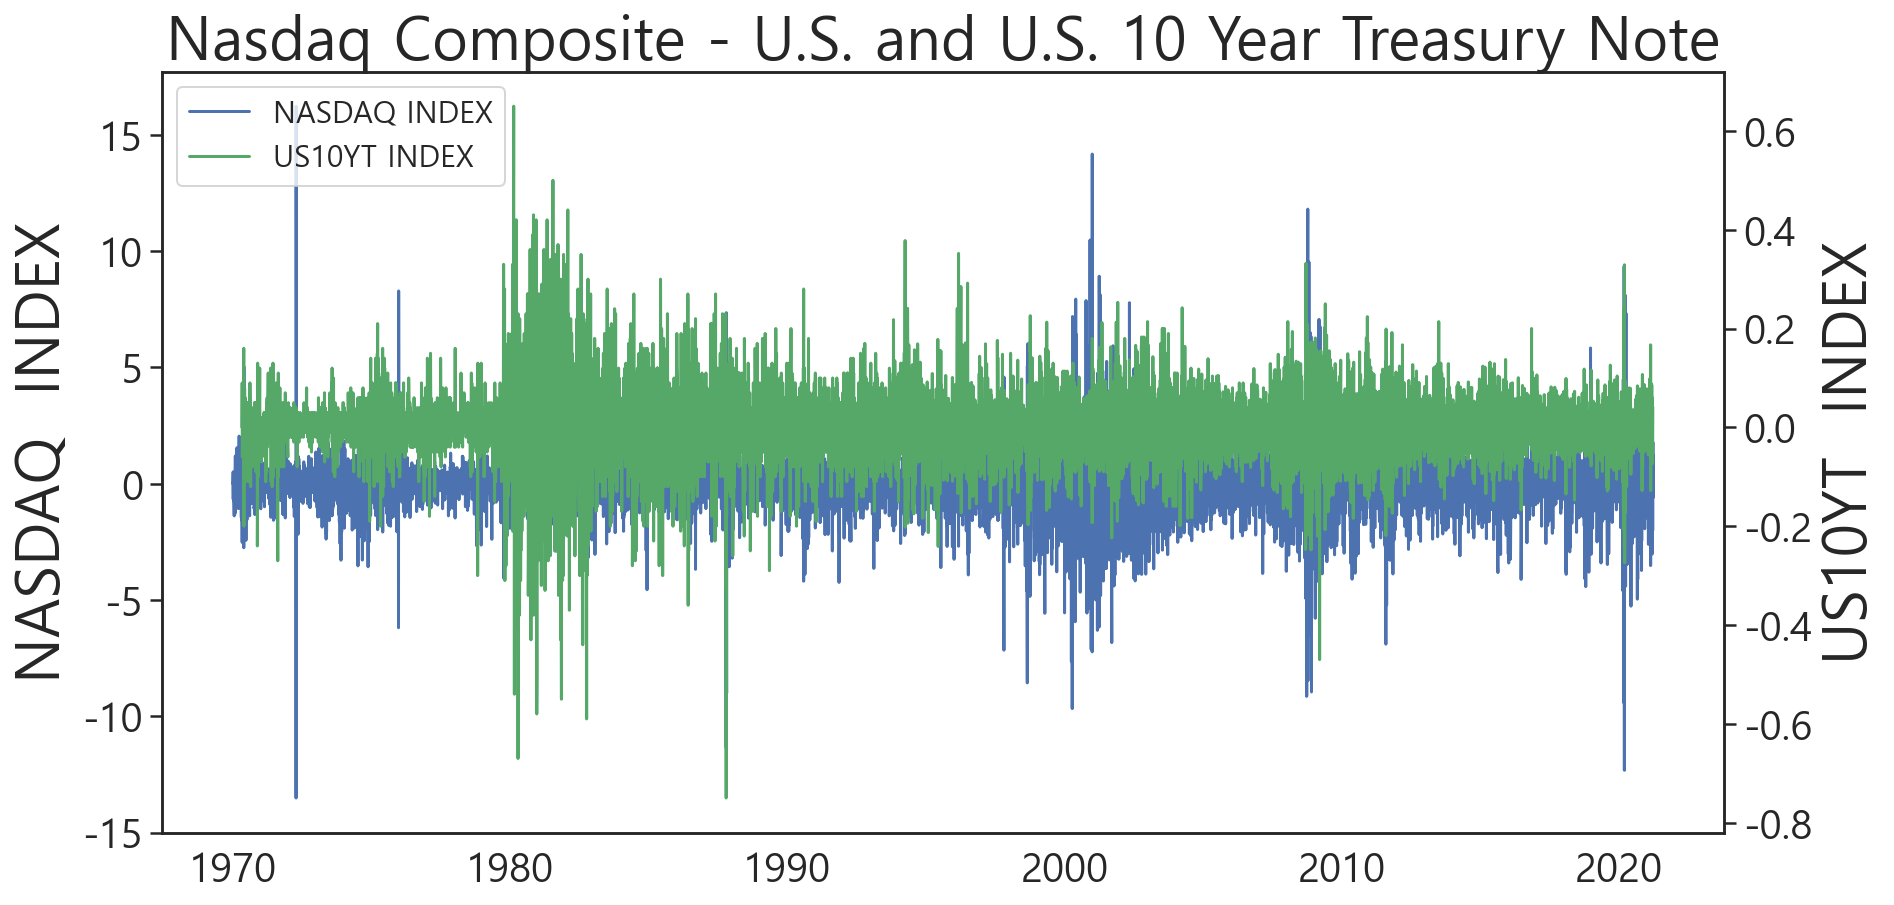

In [162]:
# 나스닥종합 지수변동률 과 미국채 10년물 금리 변동률간 그래프
fig , ax = plt.subplots(figsize=(14,7))
ndqx = ax.plot('Date','per',data=ndq,color='b',label='NASDAQ INDEX')
ax.set_ylabel('NASDAQ  INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','per',data=ten_usy,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title('Nasdaq Composite - U.S. and U.S. 10 Year Treasury Note')
xxx = ndqx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=2)
plt.show()
#plt.savefig('7021_N10P.png',bbox_inches='tight', pad_inches=0.5)

In [18]:
# 나스닥종합지수 와 미국채 10년물관 상관관계 분석
# 상관분석은 두 변수간에 어떤 선형적 또는 비선형적 관계를 갖고 있는지를 분석하는 방법
# 두 변수간의 관계의 강도를 상관관계라고 하며, 그 정도를 파악하는 것을 상관계수라고 한다.
# 상관계수는 두 변수간의 연관된 정도를 나타낼 뿐 인과관계를 설명하는 것은 아님
# 두 데이터는 Date를 기준으로 inner merge하였고 ,ndq 데이터기준 125개의 데이터 손실이 발생했다.
df = pd.merge(ndq,ten_usy, on='Date',how='inner')
df.columns = ['Date','ndq_c','ndq_p','us10y_c','us10y_p']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12718 entries, 0 to 12717
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12718 non-null  datetime64[ns]
 1   ndq_c    12718 non-null  float64       
 2   ndq_p    12718 non-null  float64       
 3   us10y_c  12718 non-null  float64       
 4   us10y_p  12718 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 596.2 KB


In [164]:
corr= df.corr(method='pearson')
corr
# 피어슨 상관관계 결과 나스닥 종합 지수와 미국채 10년물 수익률과 상관관계는 강한 음적 상관관계에 있다고 볼 수 있다.
# 하지만 나스닥종합지수 변동률과 미국채 10년물 수익률의 변동률과의 상관관계는 거의 없다.

,ndq_c,ndq_p,us10y_c,us10y_p
ndq_c,1.000000,0.017099,-0.710399,0.002313
ndq_p,0.017099,1.000000,-0.012359,0.057993
us10y_c,-0.710399,-0.012359,1.000000,0.014219
us10y_p,0.002313,0.057993,0.014219,1.000000


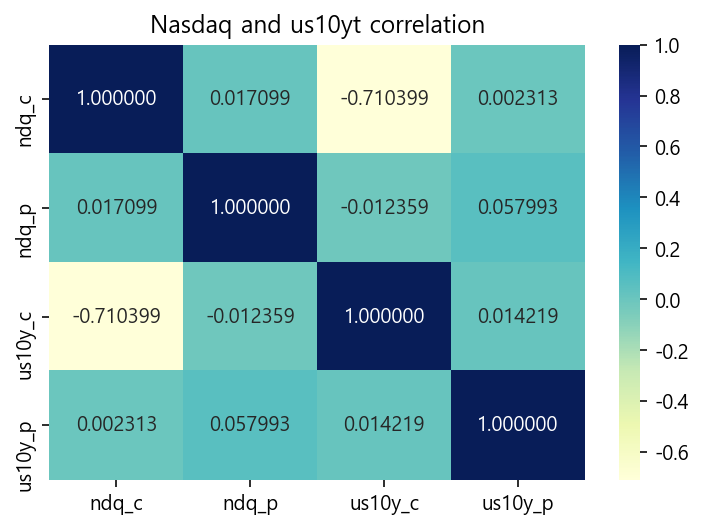

In [40]:
# corr heatmap
sns.heatmap(corr,annot=True,fmt='f',cmap='YlGnBu')
plt.title('Nasdaq and us10yt correlation')
plt.show()
#plt.savefig('Ncorr.png',bbox_inches='tight', pad_inches=0.5)

In [165]:
# 시계열 상관관계 수치를 나타내기 위한 dataset추가
# 기존데이터를 연도별 월 단위로 상관관계수치를 구하여 재편성하였다. 
t = 2021
y = 1970
m = 13
x = 0
df_Y_list = []
for i in range(t-y+1):
    h = df.loc[(df['Date'].dt.year==y+i)]
    for a in range(1,m):
        corr = h.loc[(df['Date'].dt.month==a)].corr().values[0,2]
        Y = y+i
        if len(str(a))==1:
            M = '0'+str(a)
        else : 
            M = str(a)
        df_Y_list.append([Y,M,corr])
df_corr = pd.DataFrame(df_Y_list,columns=['Date','Month','corr'])
df_corr = df_corr.dropna()

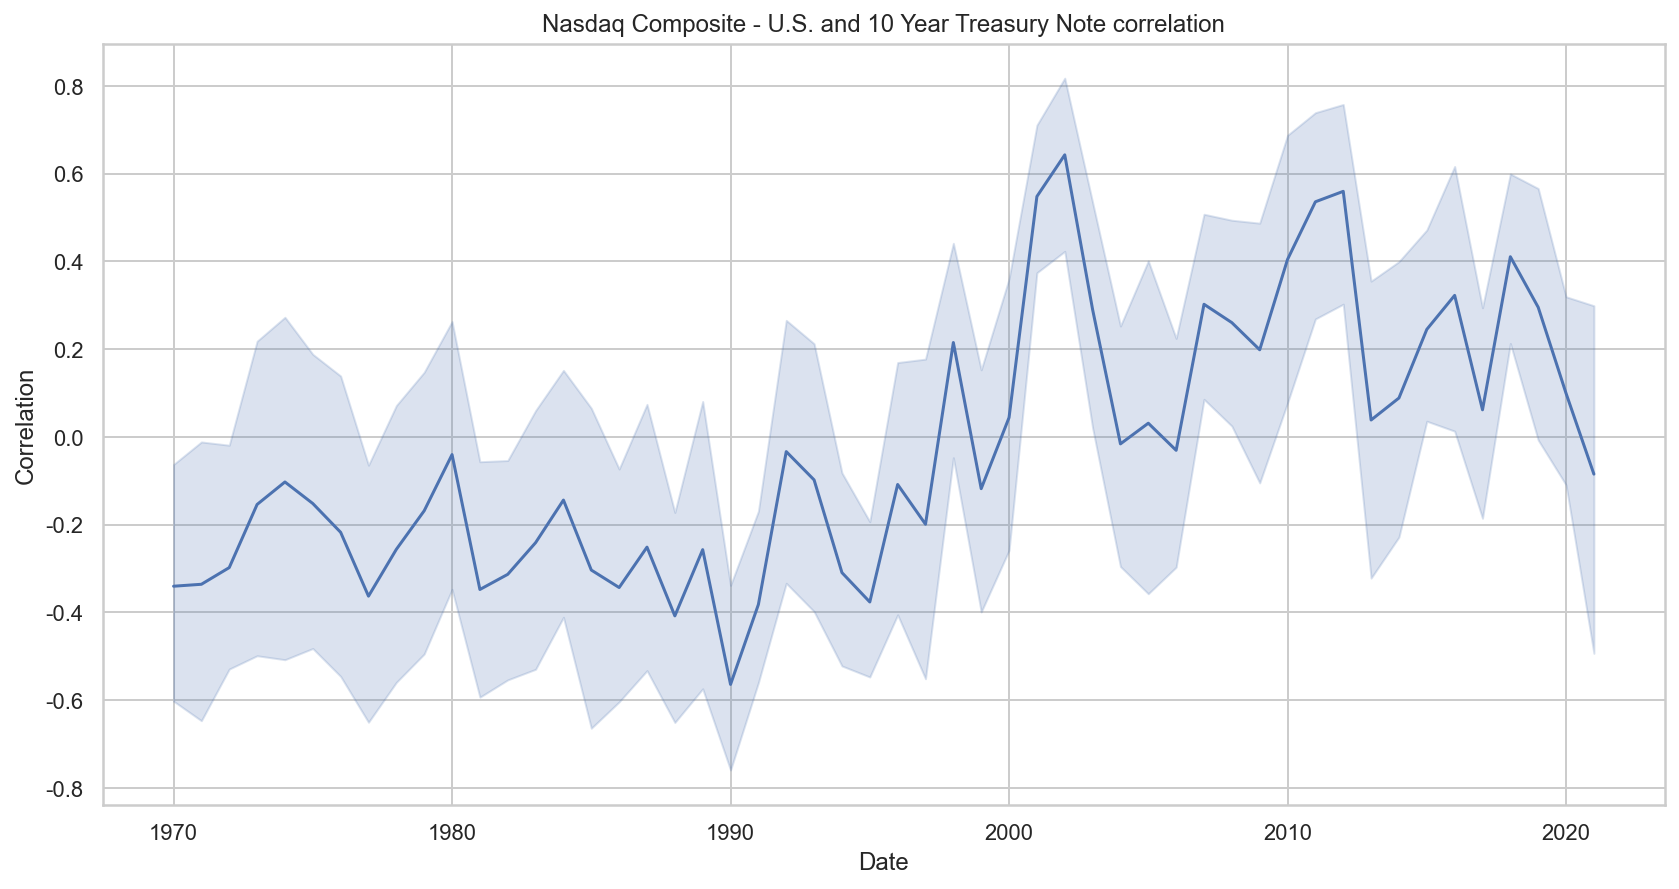

In [167]:
# 연도별 나스닥종합지수와 미국채 10년물 수익률간 상관관계 선 그래프
plt.figure(figsize=(14,7))
sns.set(palette='deep',style='whitegrid')
n10c= sns.lineplot(x='Date',y='corr',data=df_corr)
n10c.set_ylabel('Correlation')
plt.title('Nasdaq Composite - U.S. and 10 Year Treasury Note correlation')
plt.show()
# plt.savefig('7021_N10C.png',bbox_inches='tight', pad_inches=0.5) 

In [ ]:
# 1970년에서 현재까지 나스닥 종합지수와 미국채 10년물 수익률간 상관관계 전체를 비교한 
# 상관관계 수치는 강한 음적관계로 서로 역행적인 관계로 봤으나 이를 연도별로 나누어 비교했을때
# 2000년도 이전까지는 음의 상관관계 였다면 2000년도 이후 급격한 상승과 하락이 보이고 있지만 
# 상대적으로 양적 상관관계로 가까워지고 있음을 알 수 있다.
# 최근의 하락은 나스닥에 기술관련회사가 많기 때문, 기술산업은 돈을 빌려 투자하는데 국채금리가 상승하니 이자비용 증가할 수 있다.
# 이는 매출액의 감소로 이어질 수 있기 때문에 투자자들이 대거 주식을 팔아치움으로 나타난 결과다.

In [179]:
# 최소자승법을 활용한 회귀선 Fitting 
# 선형 회귀식은 y = α + βX (y=종속 변수, α=y절편(intercept), β=회귀계수) 
# OLS는 최소자승법으로 회귀 모델을 구하는 메소드
# ndq와 us10y 간 회귀분석
# intercept(절편) column을 추가. 
# 거의 모든 회귀 모델에서 intercept column을 추가해야 한다고함. 
# https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model
df['intercept']=1
res = sm.OLS(df['ndq_c'],df[['intercept','us10y_c']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ndq_c   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                 1.296e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:12:08   Log-Likelihood:            -1.1252e+05
No. Observations:               12718   AIC:                         2.250e+05
Df Residuals:                   12716   BIC:                         2.251e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5268.9720     32.983    159.750      0.000    5204.321    5333.623
us10y_c     -541.8303      4.760   -113.823      0.000    -551.161    -532.499
==============================================================================
Omnibus:                     5039.316   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21509.595
Skew:                           1.942   Prob(JB):                         0.00
Kurtosis:                       8.051   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 분석 결론
# https://mindscale.kr/course/basic-stat-python/11/
# https://bkshin.tistory.com/entry/DATA-17-Regression
# https://velog.io/@pyose95/Data-Analysis-15.-%EB%8B%A8%EC%88%9C%EC%84%A0%ED%98%95-%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D-Simple-Linear-Regression-Analysis-2
# intercept의 coef는 5268.9720 ,us10y_c 의 coef 는 -541.8303
# 이는 α=5268.9720,β=-541.8303을 말함.
# 따라서 선형회귀식은 Y = 5269 - 542X (소수점 반올림 )
# β가 1증가할때마다 α는 541 감소한다.
# intercept의 p-value는 0, us10y_c의 p-value도 0
# us10y_c에 대한 정보는 통계적으로 유의하고, intercept에 대한 정보는 통계적으로 유의하지 않다.
# R-squared는 결정계수
# 결정 계수(coefficient of determination)는 추정한 선형 모형이 주어진 자료에 적합한 정도를 재는 척도이다.
# 0과 1사이에 값이 있고 종속 변인과 독립변인 사이에 상관관계가 높을수록 1에 가까워진다.
# 0.505 이므로, us10y_c가 ndq_c에 대해 50.5%만큼 설명한다고 볼 수 있다.

In [ ]:
## 결과 보고
# 모형 적합도
# ndq_c에 대하여 us10y_c로 예측하는 회귀분석을 실시한 결과
# 이 회귀모형은 통계적으로 유의미하였다.(F(1,12716)=1.296e+04,p<0.05)
# 회귀계수
# us10y_c의 회귀계수는 -514.8303으로, ndq_c에 대하여 유의미한 예측변인인
# 것으로 나타났다.(t(12716)=-113.823,p<0.05)
# 결정계수
# us10y_c가 ndq_c를 50.5프로만큼 설명한다.

### 3.2 S&P500지수와 미국채 10년물 수익률 간 분석

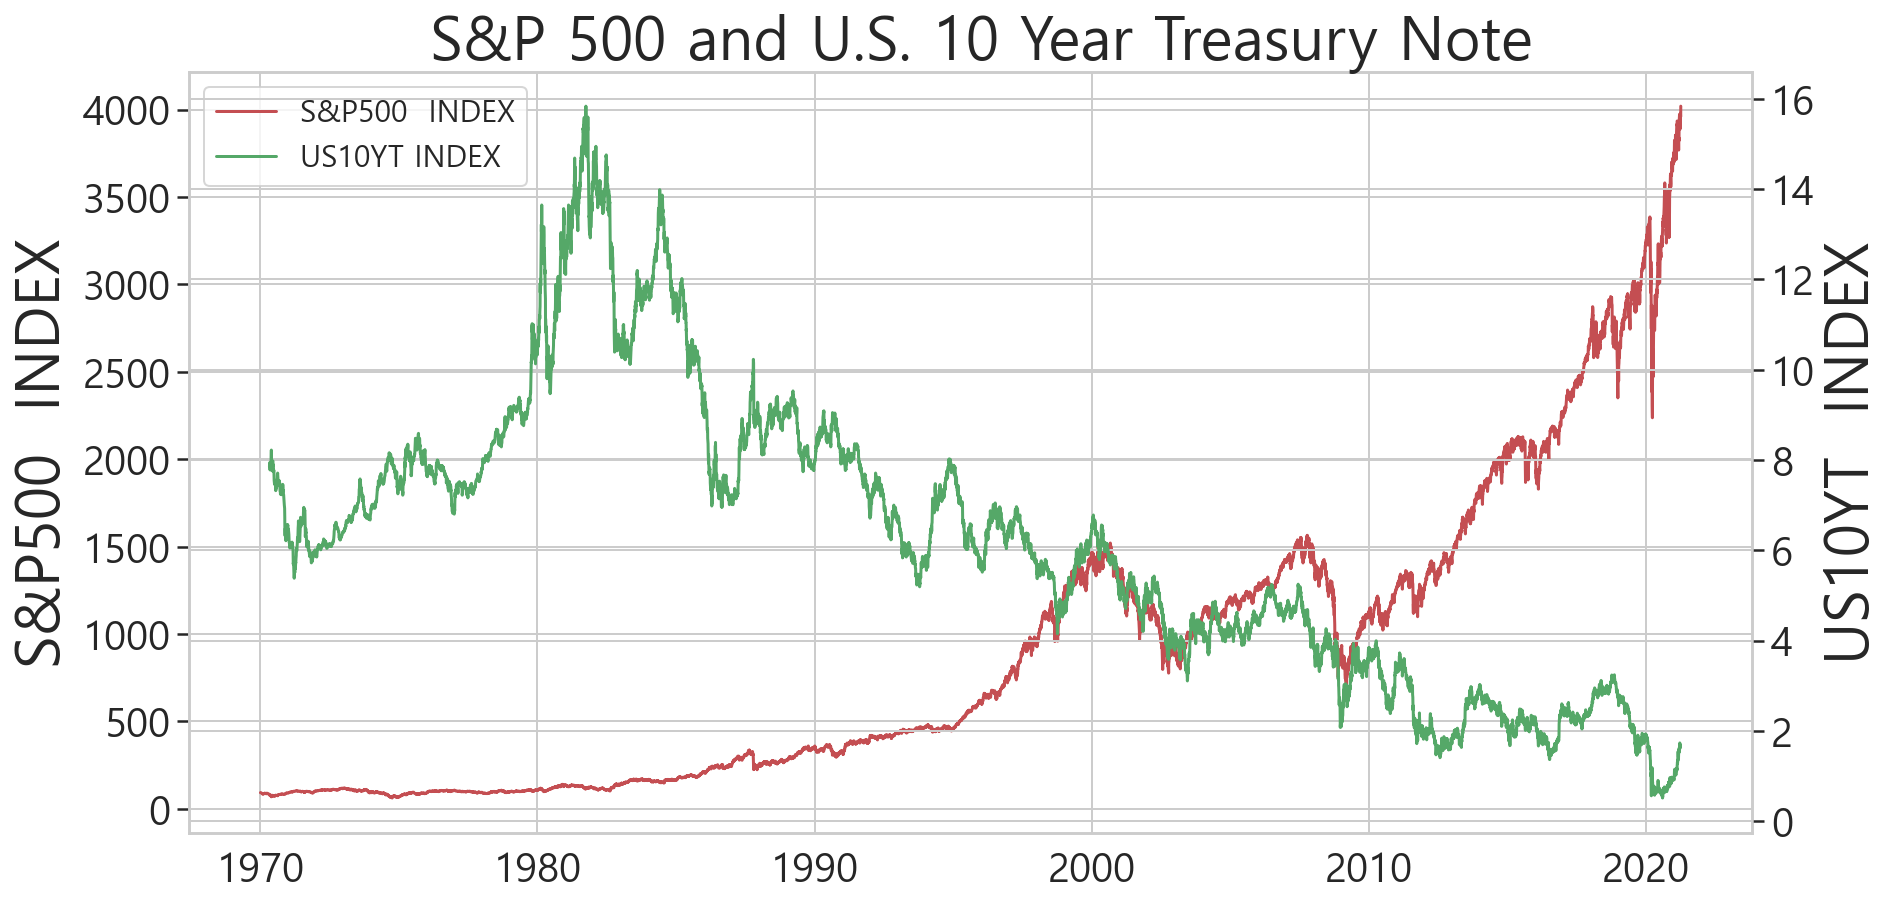

In [180]:
# S&P500지수와 미국채 10년물 수익률간 선 그래프
fig , ax = plt.subplots(figsize=(14,7))
spxx = ax.plot('Date','Close',data=spx,color='r',label='S&P500  INDEX')
ax.set_ylabel('S&P500  INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','Close',data=ten_usy,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' S&P 500 and U.S. 10 Year Treasury Note')
xxx = spxx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=2)
plt.show()
#plt.savefig('7021_S10.png',bbox_inches='tight', pad_inches=0.5) 

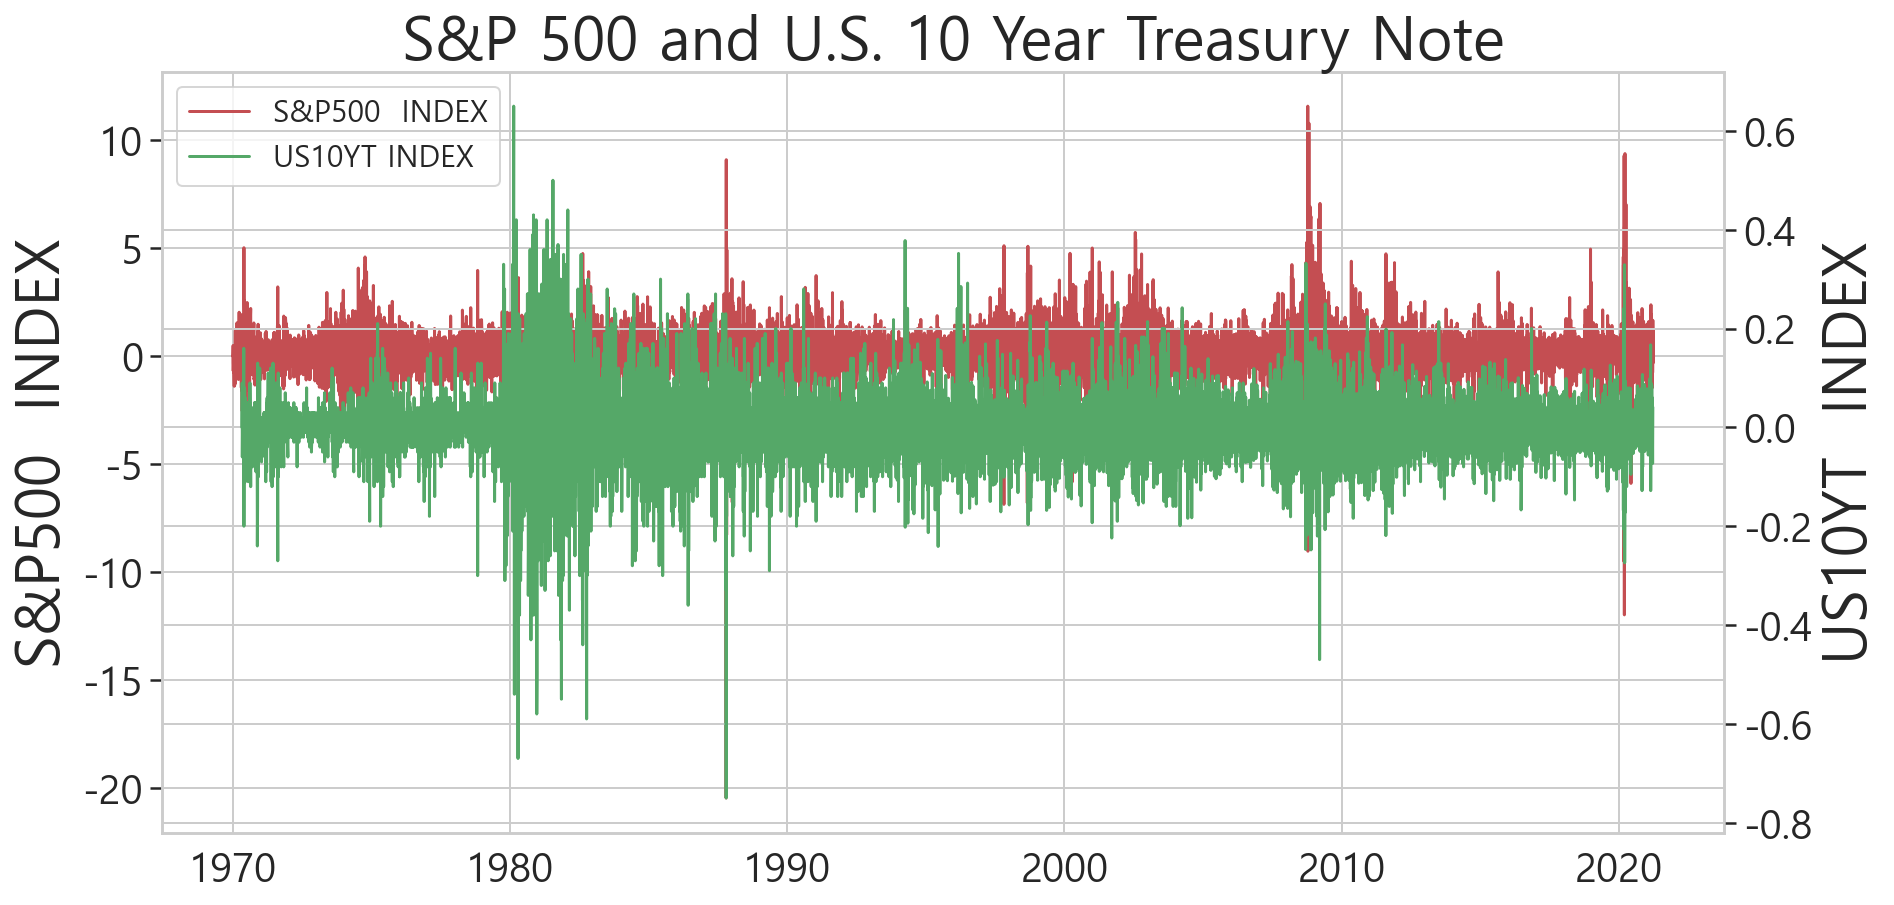

In [182]:
# S&P500지수 변동률 과 미국채 10년물 수익률 변동률간 그래프
fig , ax = plt.subplots(figsize=(14,7))
spxx = ax.plot('Date','per',data=spx,color='r',label='S&P500  INDEX')
ax.set_ylabel('S&P500  INDEX')
ax2 = ax.twinx()
ten_usyx = ax2.plot('Date','per',data=ten_usy,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' S&P 500 and U.S. 10 Year Treasury Note')
xxx = spxx+ten_usyx
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=2)
plt.show()
#plt.savefig('7021_S10P.png',bbox_inches='tight', pad_inches=0.5) 
# 여담
# -22프로 빠진날 1987-10-19 
# 미국은 레이거노믹스 밑에서 호황을 누렸지만, 
# 재정적자와 경상수지 적자는 악화되었고 금융시장은 과열조짐을 보이기 시작했다. 
# 이에 대한 투자자들의 우려가 반영된 것이 검은 월요일이다
# 이후 연방준비제도 FED에서 금리를 낮추고 통화량을 증가시켜 경제위기 모면함.

In [89]:
len(spx)

12931

In [88]:
len(df2)

12719

In [20]:
#두 Dataset을 Date를 기준으로 Inner merge하였고, spx 데이터 기준 212개의
# 데이터 손실이 발생했다.

df2 = pd.merge(spx,ten_usy, on='Date',how='inner')
df2.columns = ['Date','spx_c','spx_p','us10y_c','us10y_p']
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12719 entries, 0 to 12718
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12719 non-null  datetime64[ns]
 1   spx_c    12719 non-null  float64       
 2   spx_p    12719 non-null  float64       
 3   us10y_c  12719 non-null  float64       
 4   us10y_p  12719 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 596.2 KB


In [21]:
corr = df2.corr(method='pearson')
corr
# 피어슨 상관관계 결과 S&P500지수와 미국채 10년물 수익률과 상관관계는 음적 상관관계에 있다고 볼 수 있다.
# 하지만 S&P500지수 변동률과 미국채 10년물 수익률 변동률과 상관관계는 거의없는것으로 나타남.

,spx_c,spx_p,us10y_c,us10y_p
spx_c,1.000000,0.012662,-0.788750,0.000722
spx_p,0.012662,1.000000,-0.009072,-0.009957
us10y_c,-0.788750,-0.009072,1.000000,0.014214
us10y_p,0.000722,-0.009957,0.014214,1.000000


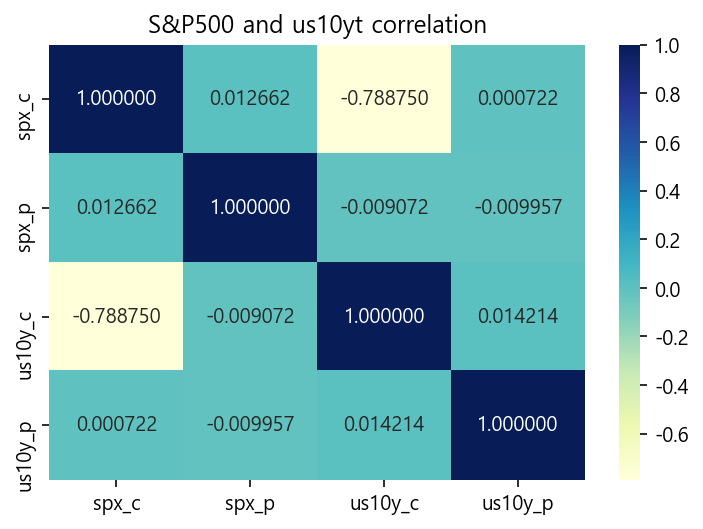

In [38]:
# corr heatmap
sns.heatmap(corr,annot=True,fmt='f',cmap='YlGnBu')
plt.title('S&P500 and us10yt correlation')
plt.show()
#plt.savefig('Kcorr.png',bbox_inches='tight', pad_inches=0.5)

In [54]:
# 시계열 상관관계 수치를 나타내기 위한 dataset추가
# 기존데이터를 연도별 월 단위로 상관관계수치를 구하여 재편성하였다. 
t = 2021
y = 1980
m = 13
x = 0
df2_Y_list = []
for i in range(t-y+1):
    h = df2.loc[(df2['Date'].dt.year==y+i)]
    for a in range(1,m):
        corr = h.loc[(df2['Date'].dt.month==a)].corr().values[0,2]
        Y = y+i
        if len(str(a))==1:
            M = '0'+str(a)
        else : 
            M = str(a)
        df2_Y_list.append([Y,M,corr])
df2_corr = pd.DataFrame(df2_Y_list,columns=['Date','Month','corr'])
df2_corr = df2_corr.dropna()

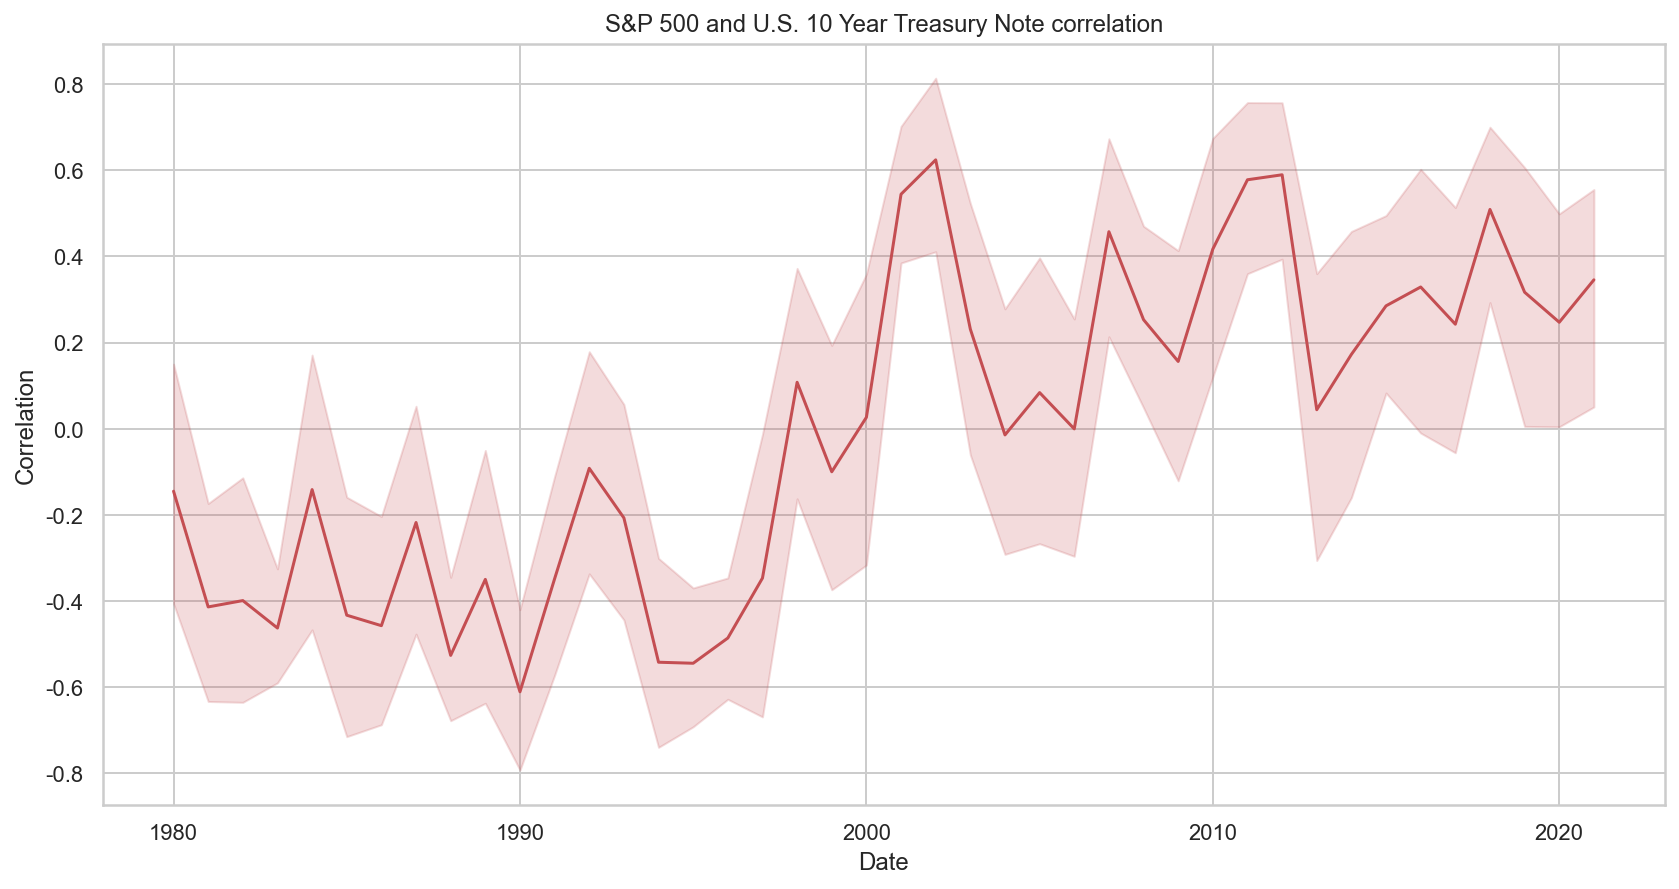

In [55]:
# 연도별 S&P500지수와 미국채 10년물 수익률간 상관관계 선 그래프
plt.figure(figsize=(14,7))
sns.set(palette='deep',style='whitegrid')
s10c = sns.lineplot(x='Date',y='corr',data=df2_corr, color='r')
s10c.set_ylabel('Correlation')
plt.title('S&P 500 and U.S. 10 Year Treasury Note correlation')
plt.show()
#plt.savefig('7021_S10C.png',bbox_inches='tight', pad_inches=0.5) 

In [ ]:
# 위 나스닥 지수와 마찬가지로 2000년을 분기점으로 양의 상관관계에 가까워짐을 알수있다.

In [181]:
# spx와 us10y 간 회귀분석
df2['intercept']=1
res = sm.OLS(df2['spx_c'],df2[['intercept','us10y_c']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spx_c   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 2.094e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:21:47   Log-Likelihood:                -97567.
No. Observations:               12719   AIC:                         1.951e+05
Df Residuals:                   12717   BIC:                         1.952e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2198.7673     10.171    216.178      0.000    2178.830    2218.704
us10y_c     -212.4087      1.468   -144.697      0.000    -215.286    -209.531
==============================================================================
Omnibus:                     1574.226   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2258.499
Skew:                           0.947   Prob(JB):                         0.00
Kurtosis:                       3.820   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## 결과 보고
# 모형 적합도
# spx_c에 대하여 us10y_c로 예측하는 회귀분석을 실시한 결과
# 이 회귀모형은 통계적으로 유의미하였다.(F(1,12717)=2.094e+04,p<0.05)
# 회귀계수
# us10y_c의 회귀계수는 -212.4087으로, spx_c에 대하여 유의미한 예측변인인
# 것으로 나타났다.(t(12717)=-144.697,p<0.05)
# 결정계수
# us10y_c가 spx_c를 60.2프로만큼 설명한다.

### 3.3 KOSPI지수와 미국채 10년물 수익률 간 분석

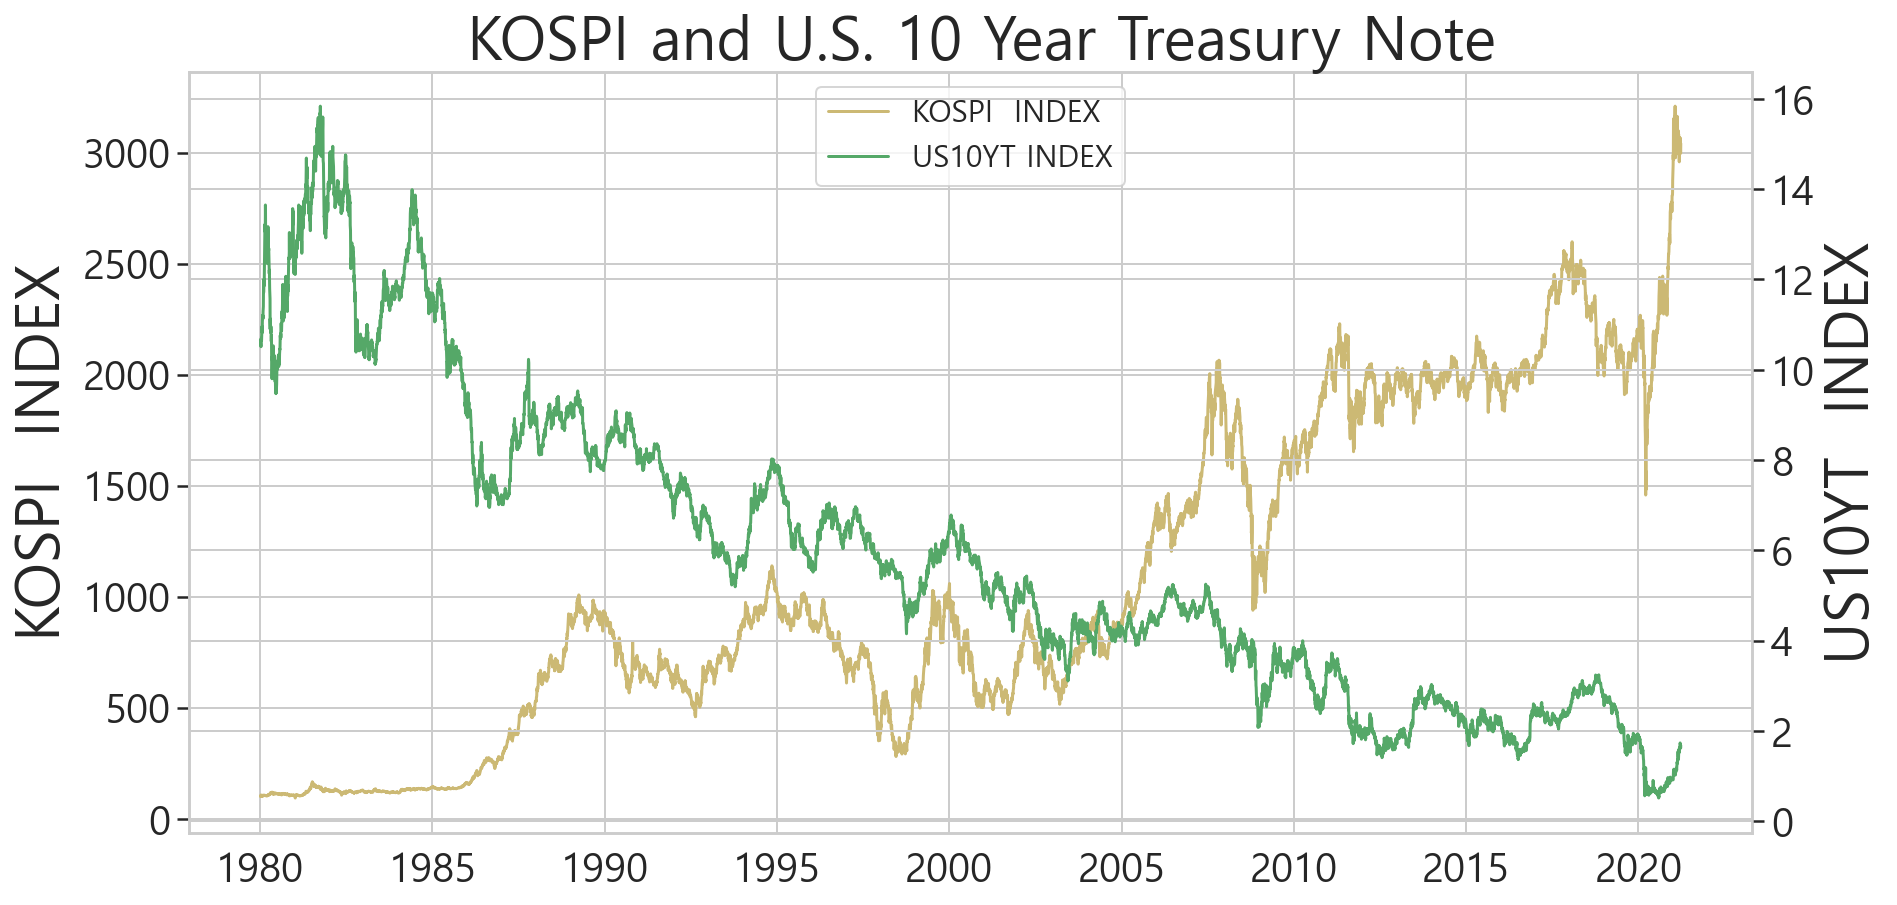

In [187]:
# Kospi지수와 미국채 10년물 수익률간 선 그래프
fig , ax = plt.subplots(figsize=(14,7))
kospix = ax.plot('Date','Close',data=kospi,color='y',label='KOSPI  INDEX')
ax.set_ylabel('KOSPI  INDEX')
ax2 = ax.twinx()
ten_usy80x = ax2.plot('Date','Close',data=ten_usy80,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' KOSPI and U.S. 10 Year Treasury Note')
xxx = kospix+ten_usy80x
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc='upper center')
plt.show()
#plt.savefig('8021_K10.png',bbox_inches='tight', pad_inches=0.5) 

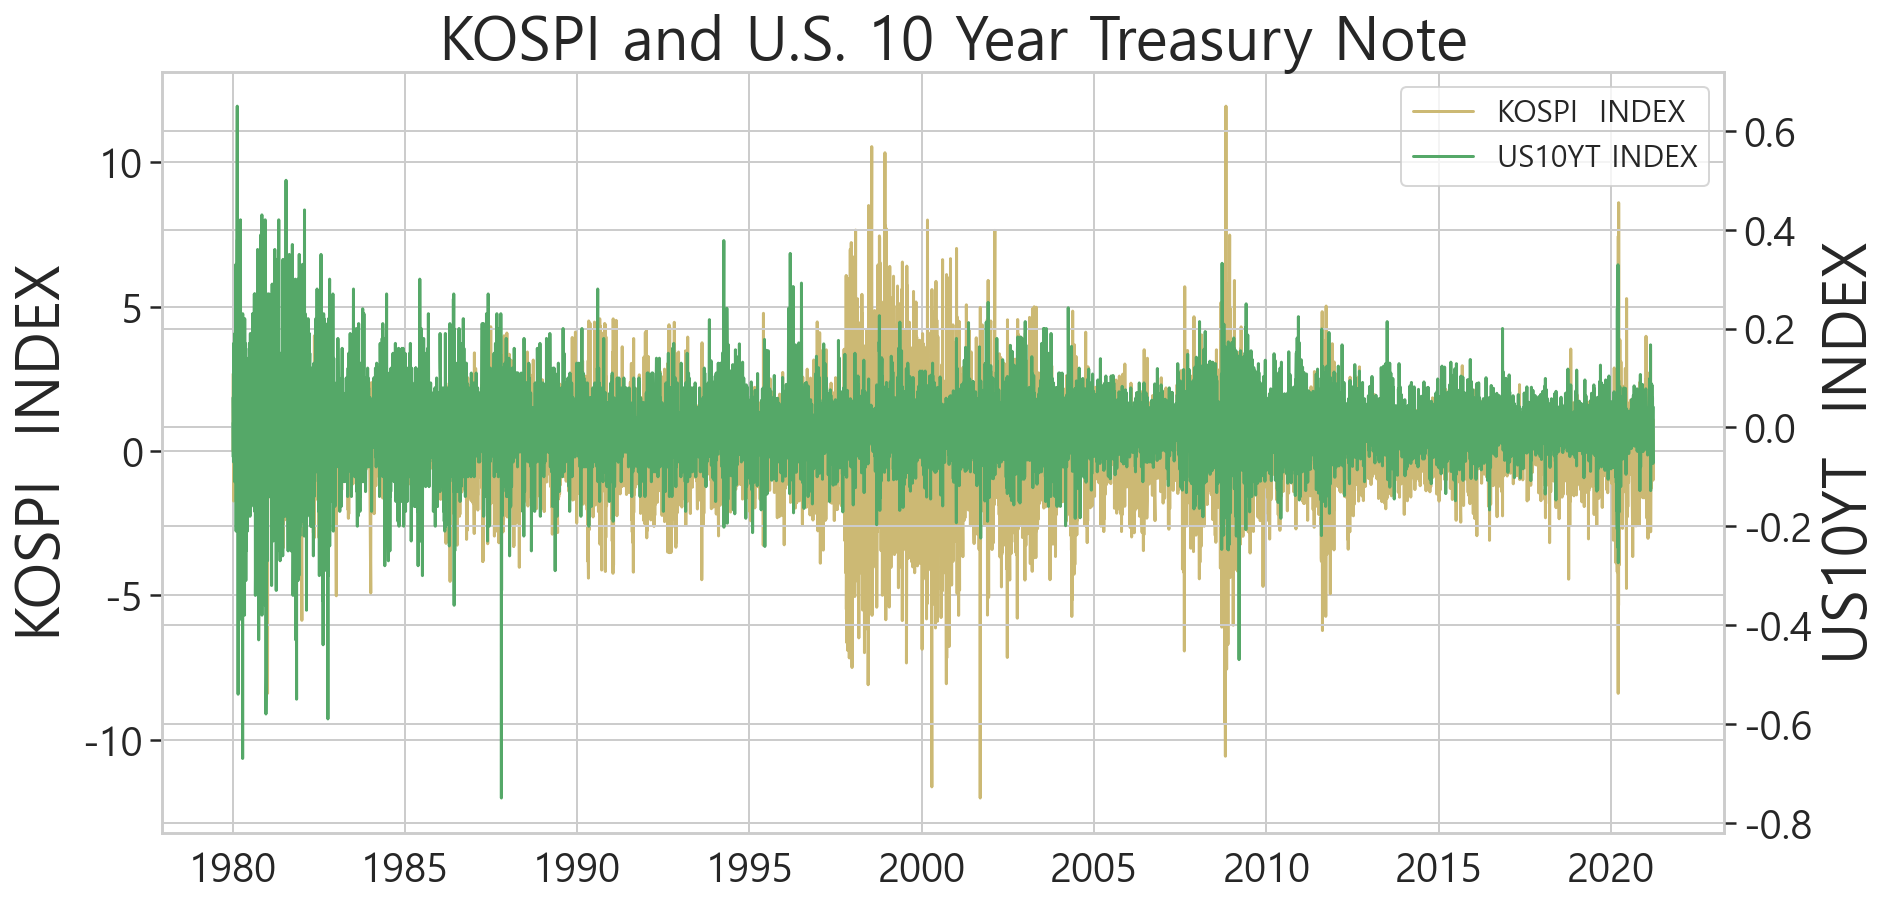

In [191]:
# KOSPI지수 변동률 과 미국채 10년물 수익률 변동률간 그래프
fig , ax = plt.subplots(figsize=(14,7))
kospix = ax.plot('Date','per',data=kospi,color='y',label='KOSPI  INDEX')
ax.set_ylabel('KOSPI  INDEX')
ax2 = ax.twinx()
ten_usy80x = ax2.plot('Date','per',data=ten_usy80,color='g',label='US10YT INDEX')
ax2.set_ylabel('US10YT  INDEX')
plt.title(' KOSPI and U.S. 10 Year Treasury Note')
xxx = kospix+ten_usy80x
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=1)
plt.show()
#plt.savefig('8021_K10P.png',bbox_inches='tight', pad_inches=0.5)
# 유의미한 특징을 찾기 어렵다.

In [95]:
len(df3),len(kospi)

(9761, 11027)

In [22]:
# kospi80-01-04부터 시작 데이터셋과 ten_usy80(80-01-04부터 시작) 데이터셋을
# Date를 기준으로 inner 머지하였다. kospi 데이터셋에선 1266개의 데이터 손실이 발생했고,
# ten_usy에서는 549개의 데이터 손실이 발생했다.
df3 = pd.merge(kospi,ten_usy80, on='Date',how='inner')
df3.columns = ['Date','kospi_c','kospi_p','us10y_80_c','us10y_80_p']
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 0 to 9760
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        9761 non-null   datetime64[ns]
 1   kospi_c     9761 non-null   float64       
 2   kospi_p     9761 non-null   float64       
 3   us10y_80_c  9761 non-null   float64       
 4   us10y_80_p  9761 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 457.5 KB


In [23]:
corr = df3.corr(method='pearson')
corr
# 피어슨 상관관계 결과 KOSPI지수와 미국채 10년물 수익률과 상관관계는 음적 상관관계에 있다고 볼 수 있다.
# 하지만 KOSPI지수 변동률과 미국채 10년물 수익변동률간  상관관계는 거의 없는것으로 나타남.

,kospi_c,kospi_p,us10y_80_c,us10y_80_p
kospi_c,1.000000,0.007714,-0.832208,0.003485
kospi_p,0.007714,1.000000,-0.007293,0.046710
us10y_80_c,-0.832208,-0.007293,1.000000,0.012955
us10y_80_p,0.003485,0.046710,0.012955,1.000000


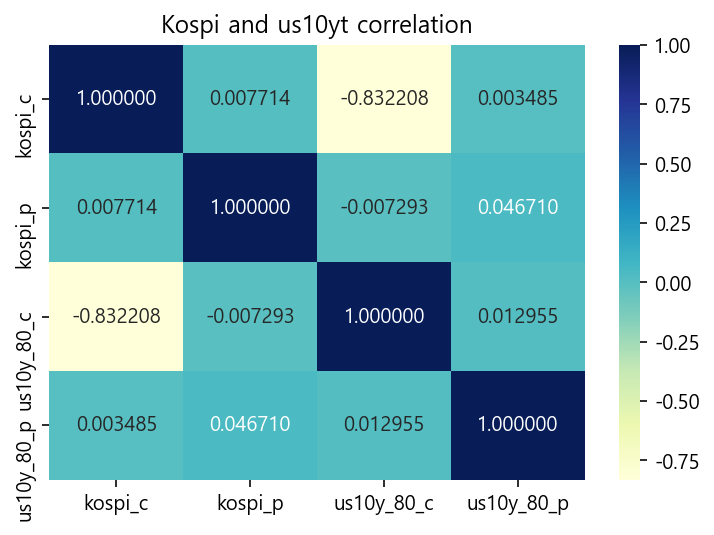

In [36]:
# corr heatmap
sns.heatmap(corr,annot=True,fmt='f',cmap='YlGnBu')
plt.title('Kospi and us10yt correlation')
plt.show()
#plt.savefig('Kocorr.png',bbox_inches='tight', pad_inches=0.5)

In [156]:
# kospi(80-01-04부터 시작)데이터셋과 ten_usy80(80-01-04부터 시작) 데이터셋을
# 연도별로 월별 상관관계 값을 데이터프레임화 하였다.
t = 2021
y = 1980
m = 13
x = 0
df3_Y_list = []
for i in range(t-y+1):
    h = df3.loc[(df3['Date'].dt.year==y+i)]
    for a in range(1,m):
        corr = h.loc[(df3['Date'].dt.month==a)].corr().values[0,2]
        Y = y+i
        if len(str(a))==1:
            M = '0'+str(a)
        else : 
            M = str(a)
        df3_Y_list.append([Y,M,corr])
df3_corr = pd.DataFrame(df3_Y_list,columns=['Date','Month','corr'])
df3_corr = df3_corr.dropna()

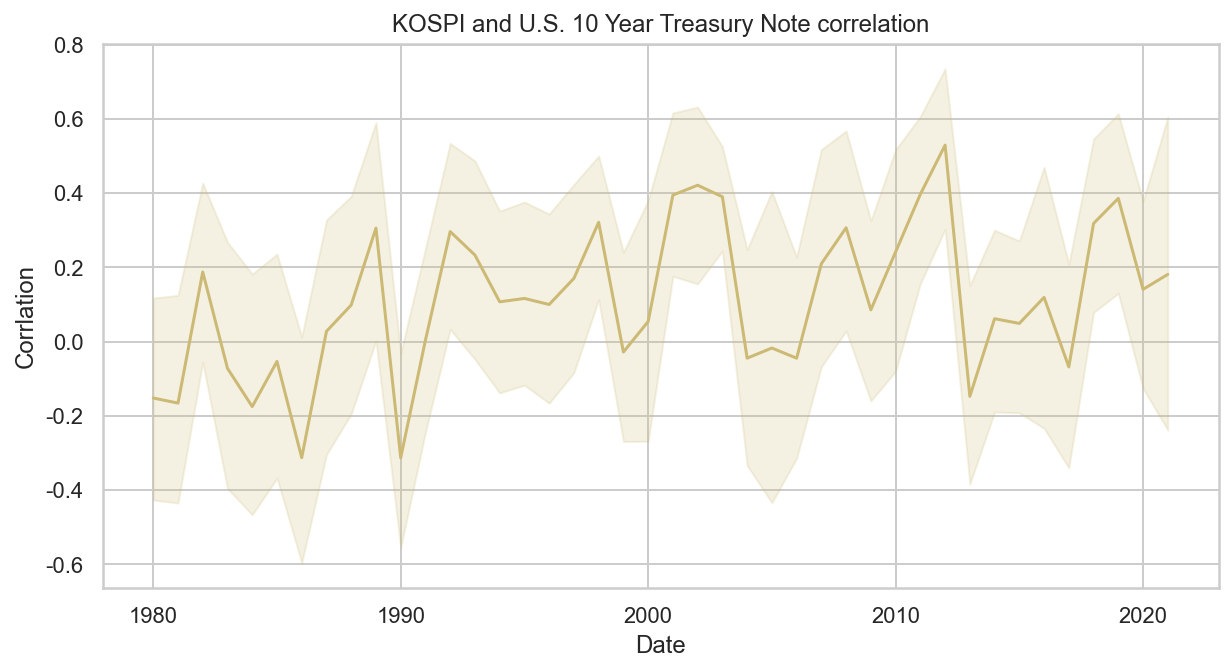

In [206]:
# 연도별 KOSPI지수와 미국채 10년물 수익률간 상관관계 선 그래프
plt.figure(figsize=(10,5))
sns.set(palette='deep',style='whitegrid')
k10c = sns.lineplot(x='Date',y='corr',data=df3_corr,color='y')
k10c.set_ylabel('Corrlation')
plt.title('KOSPI and U.S. 10 Year Treasury Note correlation')
# plt.show()
plt.savefig('8021_K10C.png',bbox_inches='tight', pad_inches=0.5)

In [ ]:
# 연도별 한국의 KOSPI지수와 미국채금리 수익율과의 상관관관계는 극적으로 양적 상관관계인지 음적상관관계인지
# 보여주지는 못했지만, 그래프 상 상대적으로 음적 상관관계보다는 양적 상관관계 쪽으로 기울어 있다고 판단된다.

In [182]:
# kospi와 us10y_80 간 회귀분석
df3['intercept']=1
res = sm.OLS(df3['kospi_c'],df3[['intercept','us10y_80_c']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                kospi_c   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                 2.198e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:29:45   Log-Likelihood:                -72427.
No. Observations:                9761   AIC:                         1.449e+05
Df Residuals:                    9759   BIC:                         1.449e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2128.2798      8.187    259.968      0.000    2112.232    2144.327
us10y_80_c  -179.5317      1.211   -148.273      0.000    -181.905    -177.158
==============================================================================
Omnibus:                       80.033   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.099
Skew:                          -0.110   Prob(JB):                     3.28e-14
Kurtosis:                       2.678   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## 결과 보고
# 모형 적합도
# kospi_c에 대하여 us10y_80_c로 예측하는 회귀분석을 실시한 결과
# 이 회귀모형은 통계적으로 유의미하였다.(F(1,9759)=2.198e+04,p<0.05)
# 회귀계수
# us10y_80_c의 회귀계수는 -179.5317으로, kospi_c에 대하여 유의미한 예측변인인
# 것으로 나타났다.(t(9759)=-148.273,p<0.05)
# 결정계수
# us10y_c가 kospi_c를 69.3프로만큼 설명한다.

# 4. Nasdaq Composite - U.S , S&P 500, KOSPI 간 선그래프 및 상관관계 분석

## 4.1 Nasdaq Composite - U.S , S&P 500, KOSPI 간 선그래프 

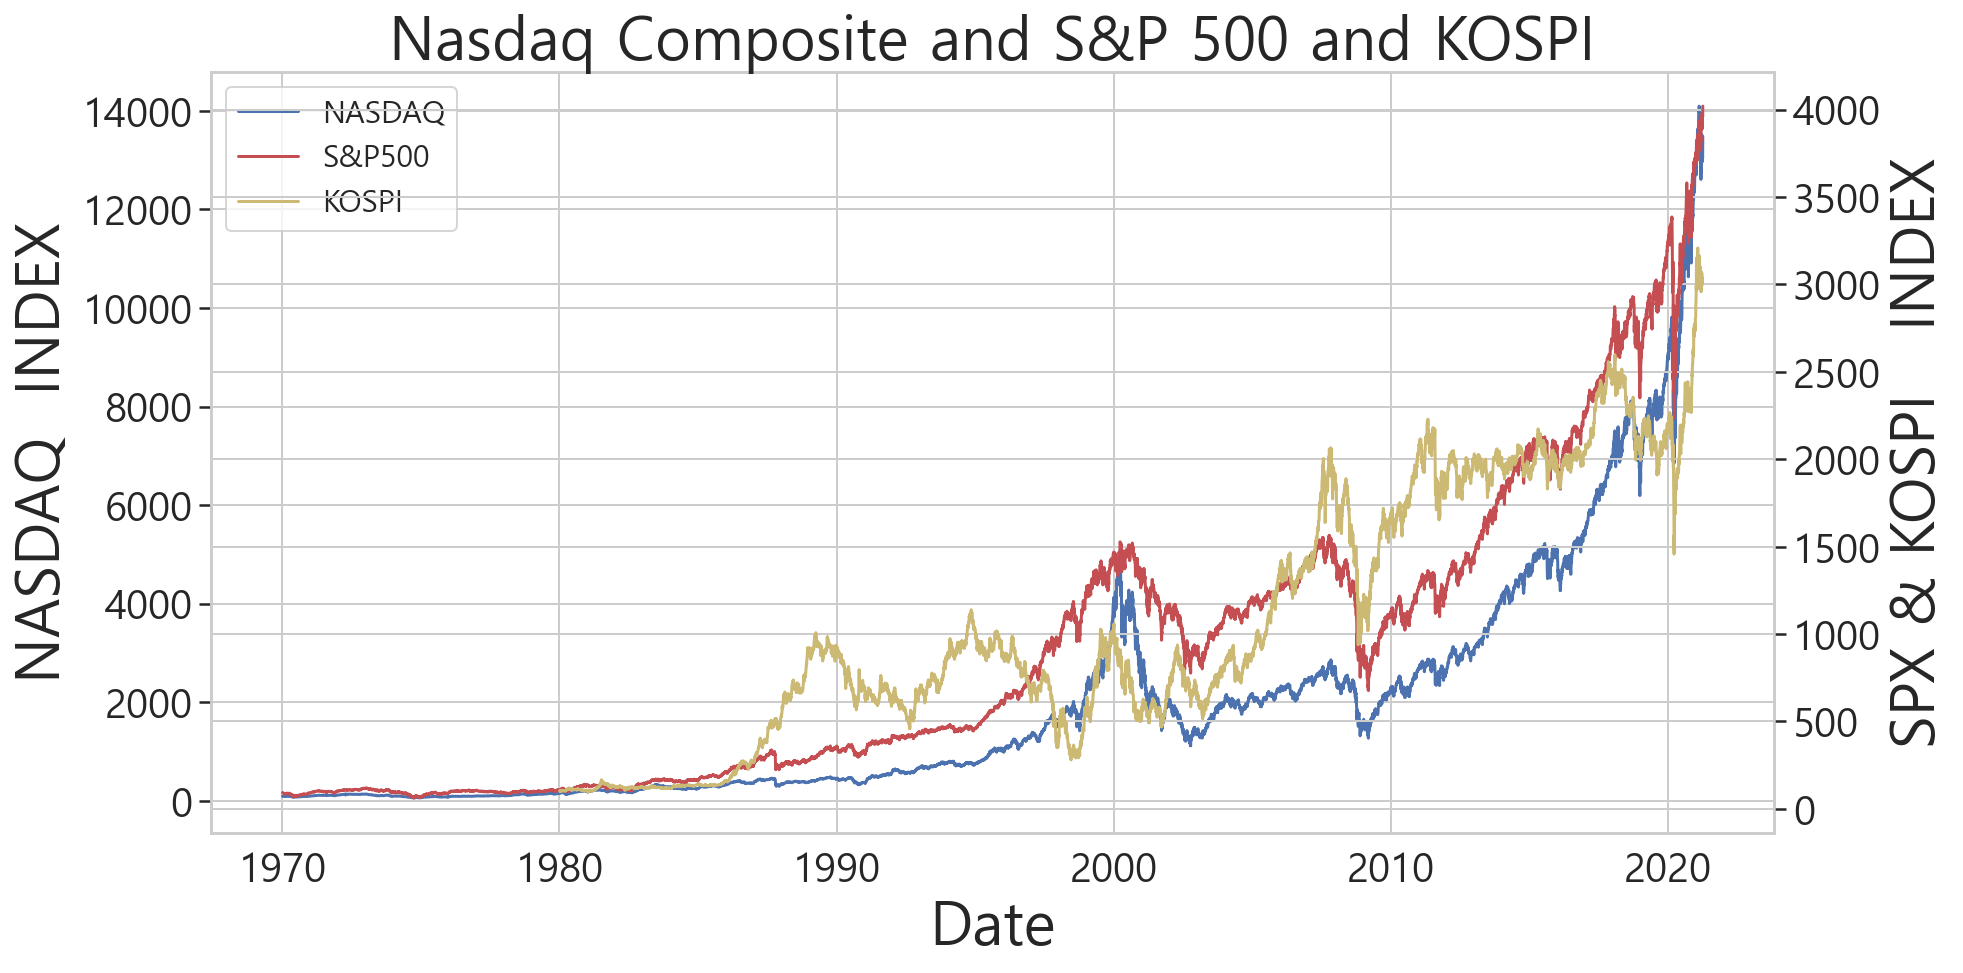

In [193]:
fig , ax = plt.subplots(figsize=(14,7))
ndqx = ax.plot('Date','Close',data=ndq,color='b',label='NASDAQ')
ax.set_ylabel('NASDAQ  INDEX')
ax.set_xlabel('Date')
ax2 = ax.twinx()
ax2.set_ylabel('SPX & KOSPI   INDEX')
spxx = ax2.plot('Date','Close',data=spx,color='r',label='S&P500')
kospix = ax2.plot('Date','Close',data=kospi,color='y',label='KOSPI')
plt.title('Nasdaq Composite and S&P 500 and KOSPI')
xxx = ndqx+spxx+kospix
labs = [l.get_label()for l in xxx]
ax.legend(xxx,labs,loc=0)
#plt.show()
plt.savefig('7021_NSK.png',bbox_inches='tight', pad_inches=0.5)

In [ ]:
# 세 지수를 년도별로 선그래프를 그렸을때 확인되는바 개별적으로 한국의 IMF같은 특정사건이 아니면 
# 큰흐름으로는 같은 방향으로 움직이고 있음을 알 수 있습니다. 2000년도 닷컴버블로 인해 거의 전 세계가 증시하락을
# 경험했고, 2008년 전세계적으로 금융위기가 닥쳐오고 리먼사태를 겪으며 동반하락하기도 합니다.
# 이후 경제회복은 더디나 증권 지수는 꾸준히 상승하였고 2020년 코로나를 겪고 또 한번
# 폭락했으나 거의 모든 증시가 1년사이 엄청난속도로 회복하게 됩니다. 결론적으로 우상향하고있는 그래프를 보여줍니다.

In [63]:
# KOSPI의 데이터셋이 80/1/4일 시작임으로 다른 두 데이터셋의 데이터 시작일을 80/1/4로
# 재편성하여 Date를 기준으로 inner 머지한다.
ndq_80=ndq.iloc[2444:]
spx_80=spx.iloc[2445:]
df4 = pd.merge(ndq_80,spx_80,on='Date',how='inner')
df4 = pd.merge(df4,kospi,on='Date',how='inner')
df4 = df4[['Date','Close_x','Close_y','Close']]
df4.columns = ['Date','ndq_c','spx_c','kospi_c']

In [64]:
corr = df4.corr(method='pearson')
corr

,ndq_c,spx_c,kospi_c
ndq_c,1.000000,0.972923,0.817844
spx_c,0.972923,1.000000,0.865143
kospi_c,0.817844,0.865143,1.000000


In [ ]:
# 나스닥과 S&P 500 지수, KOSPI지수는 서로 연관되며 강한 양적 상관관계를 나타냈다.
# 이는 주식지수가 큰확률로 동기화되어 움직인다고 판단할 수 있다.

# 번외. KOSPI와 원달러환율과의 선 그래프

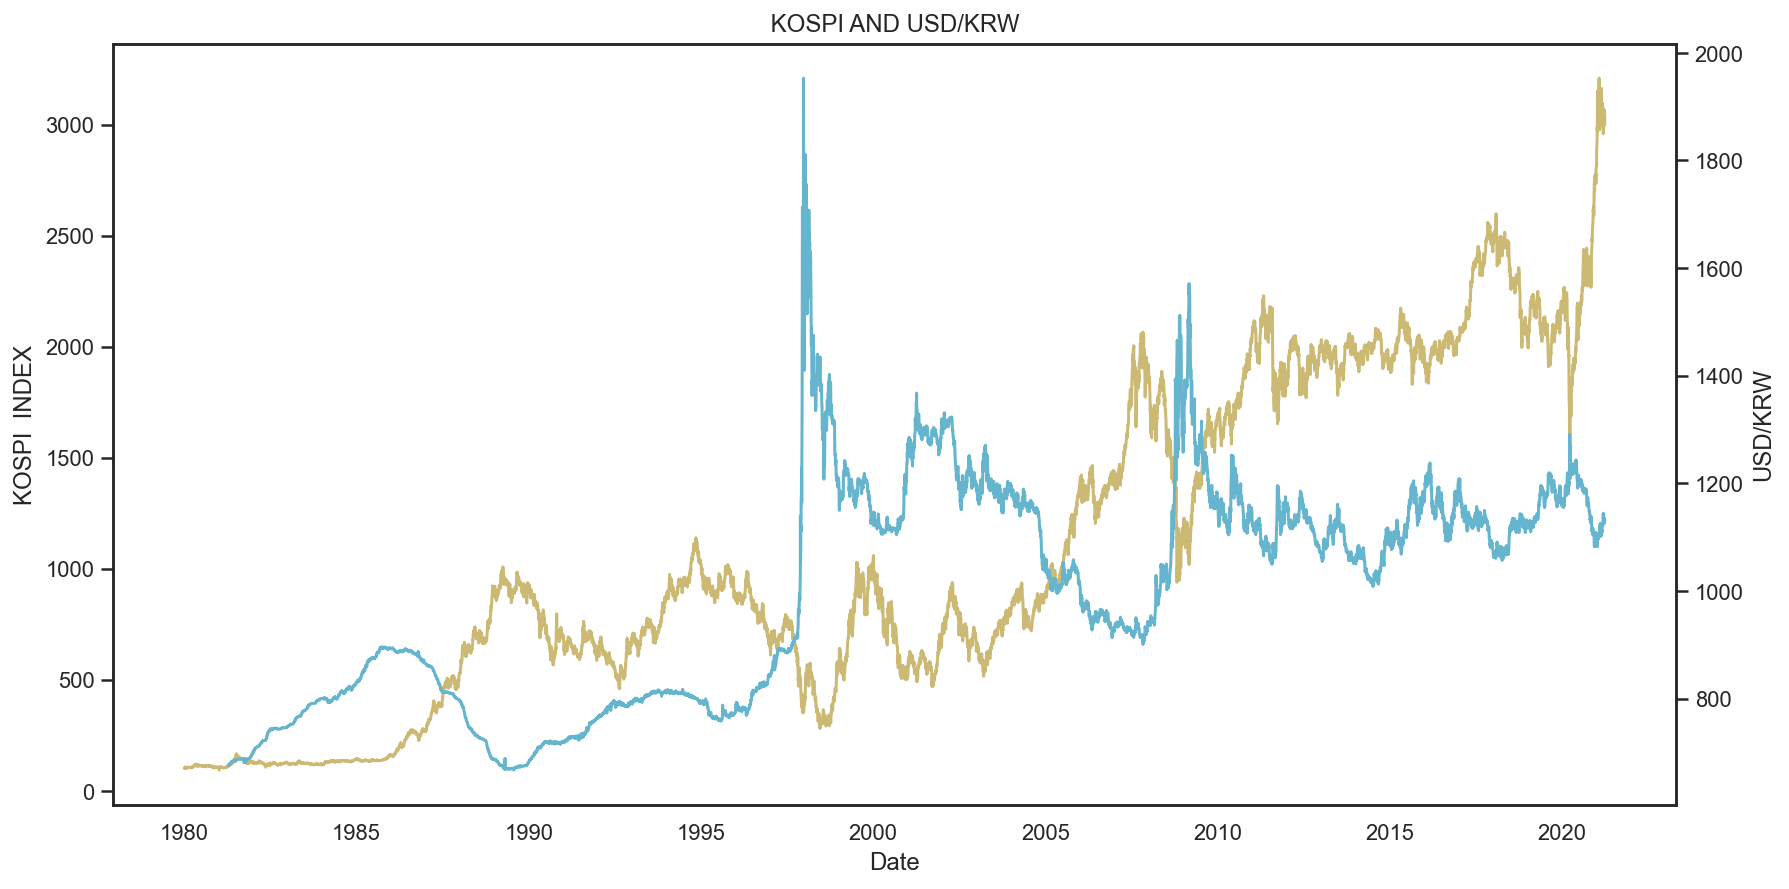

In [194]:
# Kospi지수와 원달러 환율 간 선 그래프
plt.figure(figsize=(14,7))
sns.set(palette='deep',style='white')
kuk = sns.lineplot(x='Date',y='Close',data=kospi,color='y')
kuk.set_ylabel('KOSPI  INDEX')
ten_usyx = kuk.twinx()
ten_usyx = sns.lineplot(x='Date',y='Close',data=usd_krw,color='c')
ten_usyx.set_ylabel('USD/KRW')
plt.title(' KOSPI AND USD/KRW ')
plt.show()
#plt.savefig('KUSDK.png',bbox_inches='tight', pad_inches=0.5)

In [73]:
# KOSPI의 데이터셋이 80/1/4일 시작임으로 usd_krw(81-04-13부터 시작) 데이터셋을
# 재편성하여 Date를 기준으로 inner 머지한다.
df5 = pd.merge(kospi,usd_krw,on='Date',how='inner')
df5 = df5[['Date','Close_x','Close_y']]
df5.columns = ['Date','kospi_c','usd_c']
df5.corr()
# 80~21년도 두 수치의 상관관계는 0.4로 약한 양의 상관관계를 나타낸다. 이는 위의 추세선을 보았을때 전혀 다른 수치가 나왔다.

,kospi_c,usd_c
kospi_c,1.000000,0.441822
usd_c,0.441822,1.000000


In [101]:
len(kospi),len(df5),len(usd_krw)

(11027, 9692, 10052)

In [76]:
# kospi(80-01-04부터 시작)데이터셋과 usd_krw(81-04-13부터 시작) 데이터셋을
# 연도별로 월별 상관관계 값을 데이터프레임화 하였다.
t = 2021
y = 1981
m = 13
x = 0
df5_Y_list = []
for i in range(t-y+1):
    h = df5.loc[(df5['Date'].dt.year==y+i)]
    for a in range(1,m):
        corr = h.loc[(df5['Date'].dt.month==a)].corr().values[0,1]
        Y = y+i
        if len(str(a))==1:
            M = '0'+str(a)
        else : 
            M = str(a)
        df5_Y_list.append([Y,M,corr])
df5_corr = pd.DataFrame(df5_Y_list,columns=['Date','Month','corr'])
df5_corr = df5_corr.dropna()

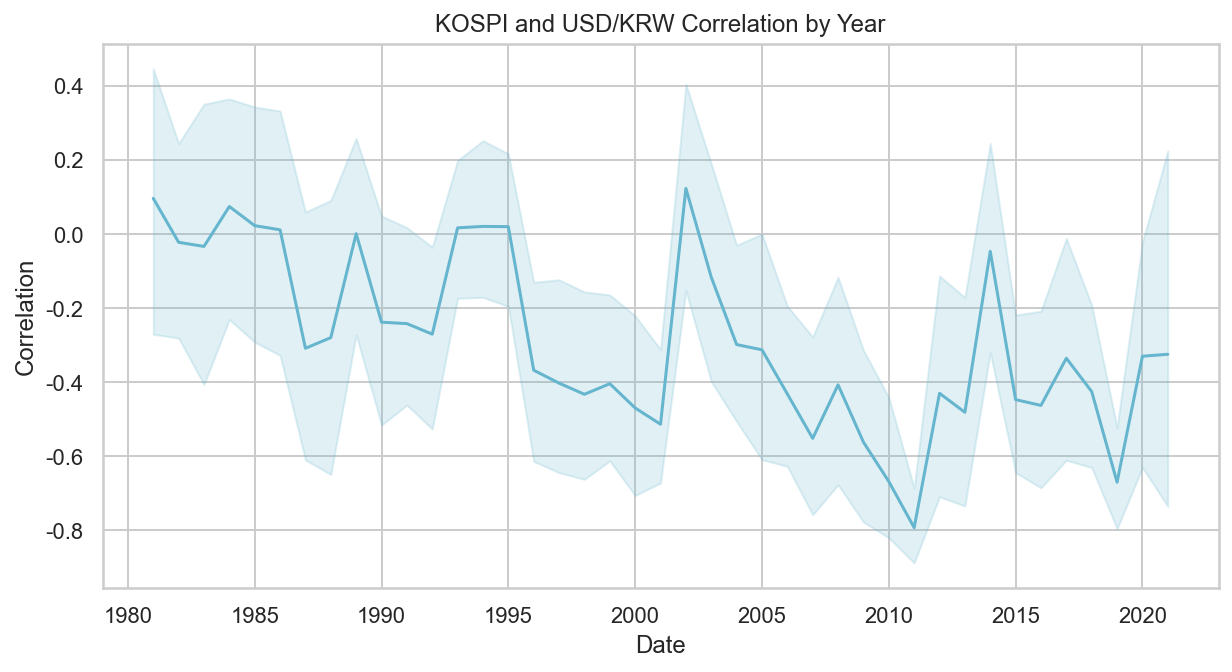

In [77]:
# 연도별 KOSPI지수와 원달러 환율간 상관관계 선 그래프
plt.figure(figsize=(10,5))
sns.set(palette='deep',style='whitegrid')
KUK=sns.lineplot(x='Date',y='corr',data=df5_corr,color='c')
KUK.set_ylabel('Correlation')
plt.title('KOSPI and USD/KRW Correlation by Year')
plt.show()
# plt.savefig('KUSDKC.png',bbox_inches='tight', pad_inches=0.5)

In [ ]:
# https://ecodemy.cafe24.com/w2-23.html
# 전체기간으로 상관관계수치가 0을 넘은적이 몇번 없다. 코스피 지수와 원달러 환율은 음의 상관관계에 놓여있다.
# 이유인 즉 환차익,환손실의 연유가 크다. 환율이 상승 한다는 것은 원화가치 하락을 말하고 이렇게 되면 
# 코스피에서 원화를 달러화로 환전할때 손실이 발생한다. 따라서 환율이 오를 것 같으면 외국인들은
# 환손실을 우려해 원화를 달러로 바꿔서 kospi시장에서 나가게됨으로 지수가 하락한다. 
# 반대로 환율이 떨어지는 추세라면 원화가치 상승을 말하기 때문에 환차익을 노리기위해서 외국자본이 kospi시장으로 들어와 지수가 올라간다.